## Angular Reconstruction, Energy Inference & Cosmic Ray Classification

In [67]:
import os
import json
import pickle
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    mean_absolute_error,
    root_mean_squared_error,
    r2_score,
)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks, optimizers, Input, Model
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Optional

In [2]:
# ----------------------------- #
# Configuración reproducible    #
# ----------------------------- #
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

os.environ.setdefault("TF_GPU_ALLOCATOR", "cuda_malloc_async")
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass
if gpus:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [3]:
# ----------------------------- #
# Paths y parámetros del flujo  #
# ----------------------------- #
BASE_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction")
CACHE_FILE = BASE_DIR / "processed_all_data.pkl"

import gdown

# Descarga el archivo processed_all_data.pkl si no existe
if not CACHE_FILE.exists():
    url = "https://drive.google.com/uc?id=1Z6EqKXUzKrlxIYcbYg1bPfNkNhfP6Pgz"
    gdown.download(url, str(CACHE_FILE), quiet=False)

ARTIFACTS_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

ENERGY_FILTER = ("3E2", "5E2", "8E2")
ANGLE_MAX = 40.0
MIN_TOTAL_PARTICLES = 30

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15  # test será 0.15 (restante)
BATCH_SIZE = 32
EPOCHS = 100

In [4]:
# ----------------------------- #
# Carga desde pickle            #
# ----------------------------- #
def load_dataset_from_cache(cache_path: Path) -> pd.DataFrame:
    if not cache_path.exists():
        raise FileNotFoundError(
            f"No se encontró {cache_path}. Regenera el pickle antes de ejecutar el pipeline."
        )
    with cache_path.open("rb") as fh:
        data = pickle.load(fh)
    if isinstance(data, pd.DataFrame):
        df = data.copy()
    elif isinstance(data, dict):
        df = pd.DataFrame(data)
    else:
        raise ValueError("Formato de caché no soportado.")
    required_cols = {"shower_data", "angle", "label", "energy", "total_particles", "max_time"}
    if not required_cols.issubset(df.columns):
        raise ValueError("El pickle no contiene todas las columnas necesarias.")
    return df.reset_index(drop=True)

df_full = load_dataset_from_cache(CACHE_FILE)

df_full = df_full[
    (df_full["energy"].isin(ENERGY_FILTER)) &
    (df_full["angle"] <= ANGLE_MAX) &
    (df_full["total_particles"] >= MIN_TOTAL_PARTICLES)
].reset_index(drop=True)
if df_full.empty:
    raise RuntimeError("No se encontraron eventos tras filtrar por energía / ángulo / partículas.")
df_full["idx"] = df_full.index

In [5]:
df_full.head()

,shower_data,angle,label,energy,total_particles,max_time,idx
0,"[[34.0, 0.0, 1.0, -10.521292, -0.18196964, -12...",0.0,1,3E2,31,28,0
1,"[[72.0, 0.0, 1.0, 23.91233, -21.620737, 21.25,...",0.0,1,3E2,92,49,1
2,"[[52.0, 0.0, 3.0, 5.457006, -21.212957, 4.25, ...",0.0,1,3E2,154,77,2
3,"[[46.0, 0.0, 1.0, -3.1485364, 15.506375, -4.25...",0.0,1,3E2,109,104,3
4,"[[64.0, 0.0, 2.0, 10.033819, -3.3683705, 12.75...",0.0,1,3E2,48,74,4


In [6]:
# ----------------------------- #
# Catálogo de detectores        #
# ----------------------------- #
def build_detector_catalog(df: pd.DataFrame) -> pd.DataFrame:
    positions = []
    for seq in df["shower_data"]:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            continue
        positions.append(arr[:, [0, 5, 6]])  # detector_id, x_center, y_center
    if not positions:
        return pd.DataFrame(columns=["detector_id", "x_center", "y_center"])
    catalog = (
        pd.DataFrame(np.vstack(positions), columns=["detector_id", "x_center", "y_center"])
        .drop_duplicates(subset=["detector_id"])
        .sort_values("detector_id")
        .reset_index(drop=True)
    )
    catalog["detector_id"] = catalog["detector_id"].astype(int)
    return catalog

detector_catalog = build_detector_catalog(df_full)
detector_catalog.to_csv(ARTIFACTS_DIR / "detector_catalog.csv", index=False)

In [7]:
detector_catalog

,detector_id,x_center,y_center
0,0,-38.250000,-40.50
1,1,-38.250000,-31.50
2,2,-38.250000,-22.50
3,3,-38.250000,-13.50
4,4,-38.250000,-4.50
...,...,...,...
115,115,50.400002,-13.50
116,116,50.400002,13.50
117,117,50.400002,40.50
118,118,50.400002,-53.75


In [8]:
def balance_by_group(df: pd.DataFrame, group_cols, random_state: int) -> tuple[pd.DataFrame, int]:
    counts = df.groupby(list(group_cols)).size()
    counts = counts[counts > 0]
    if counts.empty:
        raise RuntimeError("No hay grupos disponibles para balancear.")
    target = int(counts.median())
    balanced_parts = []
    for _, group in df.groupby(list(group_cols)):
        replace = len(group) < target
        balanced_parts.append(group.sample(n=target, replace=replace, random_state=random_state))
    balanced_df = pd.concat(balanced_parts, ignore_index=True)
    balanced_df = balanced_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return balanced_df, target

df_balanced, target_per_group = balance_by_group(
    df_full,
    group_cols=("label", "angle", "energy"),
    random_state=SEED,
)

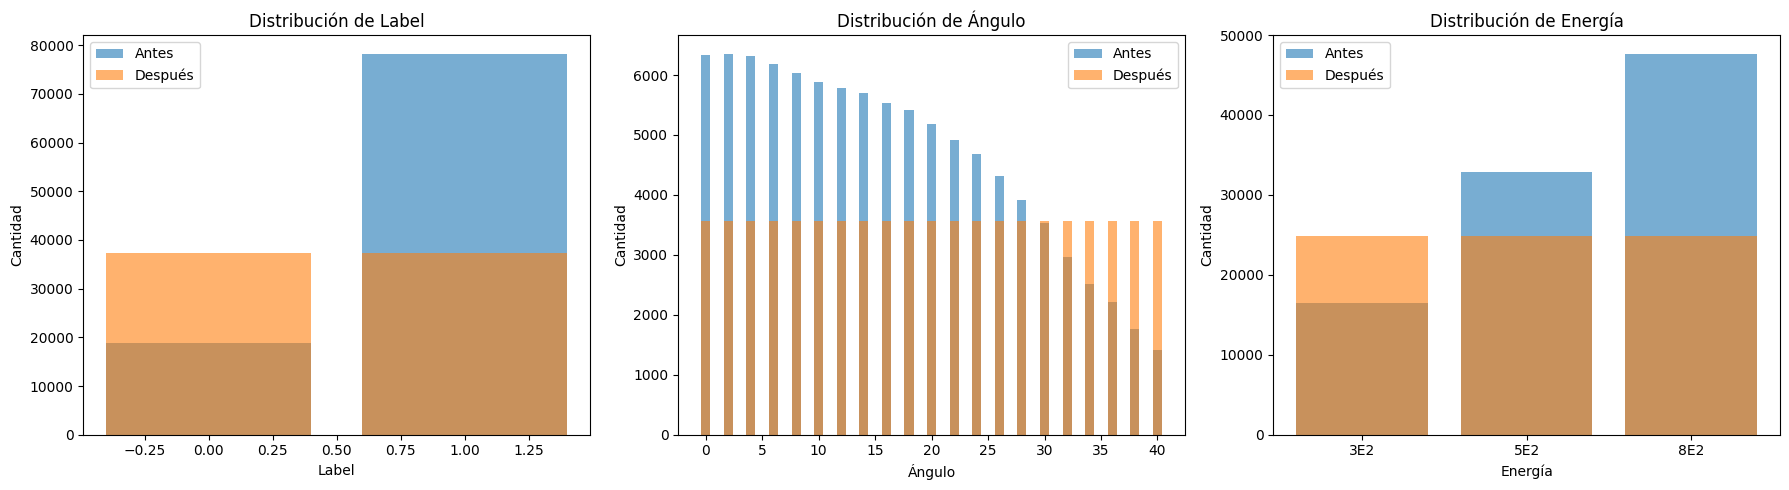

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Antes del balanceo
df_full_counts = {
    "label": df_full["label"].value_counts().sort_index(),
    "angle": df_full["angle"].value_counts().sort_index(),
    "energy": df_full["energy"].value_counts().sort_index(),
}

# Después del balanceo
df_balanced_counts = {
    "label": df_balanced["label"].value_counts().sort_index(),
    "angle": df_balanced["angle"].value_counts().sort_index(),
    "energy": df_balanced["energy"].value_counts().sort_index(),
}

features = ["label", "angle", "energy"]
titles = ["Label", "Ángulo", "Energía"]

for i, (feature, title) in enumerate(zip(features, titles)):
    ax = axes[i]
    ax.bar(df_full_counts[feature].index, df_full_counts[feature].values, alpha=0.6, label="Antes")
    ax.bar(df_balanced_counts[feature].index, df_balanced_counts[feature].values, alpha=0.6, label="Después")
    ax.set_title(f"Distribución de {title}")
    ax.set_xlabel(title)
    ax.set_ylabel("Cantidad")
    ax.legend()

plt.tight_layout()
plt.show()

In [10]:
def resumen_balanceo(df_pre, df_post):
    label_map = {0: "Photon", 1: "Proton"}
    def agregar_tabla(df, nombre):
        tabla = (
            df.assign(label=df["label"].map(label_map))
            .groupby(["energy", "label", "angle"])
            .size()
            .unstack("angle", fill_value=0)
        )
        tabla["Total"] = tabla.sum(axis=1)
        tabla["Set"] = nombre
        return tabla.reset_index()
    tabla_pre = agregar_tabla(df_pre, "Antes")
    tabla_post = agregar_tabla(df_post, "Después")
    tabla_final = pd.concat([tabla_pre, tabla_post], ignore_index=True)
    display(tabla_final)

resumen_balanceo(df_full, df_balanced)


angle,energy,label,0.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,...,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0,Total,Set
0,3E2,Photon,179,168,150,154,112,129,130,143,...,78,63,64,38,36,30,31,19,1958,Antes
1,3E2,Proton,1174,1136,1118,1071,1087,1045,979,935,...,513,415,364,287,223,197,124,90,14474,Antes
2,5E2,Photon,449,369,344,371,316,307,261,310,...,233,229,153,161,103,116,101,85,5306,Antes
3,5E2,Proton,1844,1845,1843,1812,1807,1785,1752,1683,...,1226,1075,961,721,634,526,399,287,27611,Antes
4,8E2,Photon,706,847,866,796,713,627,690,651,...,460,394,356,332,242,249,216,214,11496,Antes
5,8E2,Proton,1987,1988,1991,1986,1994,1986,1980,1979,...,1810,1740,1636,1425,1278,1091,895,725,36143,Antes
6,3E2,Photon,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después
7,3E2,Proton,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después
8,5E2,Photon,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después
9,5E2,Proton,593,593,593,593,593,593,593,593,...,593,593,593,593,593,593,593,593,12453,Después


In [11]:
# ----------------------------- #
# Construcción de secuencias    #
# ----------------------------- #
FEATURE_ORDER = [0, 2, 1, 7, 5, 6]  # detector_id, particle_count, t_bin, total_energy, x_center, y_center
FEATURE_NAMES = ["detector_id", "particle_count", "t_bin", "total_energy", "x_center", "y_center"]

def build_sequence_list(df: pd.DataFrame) -> list[np.ndarray]:
    sequences = []
    for seq in df["shower_data"]:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            sequences.append(np.zeros((0, len(FEATURE_ORDER)), dtype=np.float32))
            continue
        order = np.argsort(arr[:, 1])  # t_bin
        ordered = arr[order][:, FEATURE_ORDER].astype(np.float32)
        sequences.append(ordered)
    return sequences

X_sequences = build_sequence_list(df_balanced)
angles = df_balanced["angle"].to_numpy(dtype=np.float32)
labels = df_balanced["label"].to_numpy(dtype=np.int32)
energies = df_balanced["energy"].to_numpy()

In [12]:
# ----------------------------- #
# Features globales             #
# ----------------------------- #
detector_catalog["distance"] = np.hypot(detector_catalog["x_center"], detector_catalog["y_center"])
central_ids = detector_catalog.nsmallest(16, "distance")["detector_id"].astype(int).tolist()

def compute_global_features(sequences: list[np.ndarray], central_detectors: list[int]) -> np.ndarray:
    central_detectors = np.array(central_detectors, dtype=np.int32)
    features = np.zeros((len(sequences), 5), dtype=np.float32)
    for idx, seq in enumerate(sequences):
        if seq.size == 0:
            continue
        det_ids = seq[:, 0].astype(np.int32)
        particle_counts = seq[:, 1]
        t_bins = seq[:, 2]
        tot_energy = seq[:, 3]

        total_particles = float(particle_counts.sum())
        total_energy = float(tot_energy.sum())
        active_detectors = float(np.unique(det_ids).size)
        duration = float(t_bins.max() - t_bins.min())
        mask_central = np.isin(det_ids, central_detectors)
        energy_central = float(tot_energy[mask_central].sum()) if np.any(mask_central) else 0.0

        features[idx] = [
            total_particles,
            total_energy,
            active_detectors,
            duration,
            energy_central,
        ]
    return features

X_global = compute_global_features(X_sequences, central_ids)
X_padded = pad_sequences(X_sequences, padding="post", dtype="float32")
max_sequence_length = int(X_padded.shape[1])

In [13]:
# ----------------------------- #
# Splits estratificados         #
# ----------------------------- #
indices = np.arange(len(X_padded))
strata = np.array([f"{int(round(a))}_{lbl}" for a, lbl in zip(angles, labels)])

train_idx, temp_idx = train_test_split(
    indices,
    test_size=1.0 - TRAIN_RATIO,
    stratify=strata,
    random_state=SEED,
    shuffle=True,
)

val_fraction = VAL_RATIO / (1.0 - TRAIN_RATIO)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=1.0 - val_fraction,
    stratify=strata[temp_idx],
    random_state=SEED,
    shuffle=True,
)

def split_arrays(arr: np.ndarray, tr: np.ndarray, va: np.ndarray, te: np.ndarray):
    return arr[tr], arr[va], arr[te]

X_train, X_val, X_test = split_arrays(X_padded, train_idx, val_idx, test_idx)
Xg_train, Xg_val, Xg_test = split_arrays(X_global, train_idx, val_idx, test_idx)
y_angle_train, y_angle_val, y_angle_test = split_arrays(angles, train_idx, val_idx, test_idx)
y_label_train, y_label_val, y_label_test = split_arrays(labels, train_idx, val_idx, test_idx)
y_energy_train, y_energy_val, y_energy_test = split_arrays(energies, train_idx, val_idx, test_idx)

energy_levels = sorted({e for e in df_balanced["energy"]}, key=lambda x: float(x.replace("E", "e")))
energy_to_idx = {e: idx for idx, e in enumerate(energy_levels)}
y_energy_train_cls = np.array([energy_to_idx[e] for e in y_energy_train], dtype=np.int32)
y_energy_val_cls = np.array([energy_to_idx[e] for e in y_energy_val], dtype=np.int32)
y_energy_test_cls = np.array([energy_to_idx[e] for e in y_energy_test], dtype=np.int32)

def parse_energy(arr: np.ndarray) -> np.ndarray:
    return np.array([float(s.replace("E", "e")) for s in arr], dtype=np.float32)

y_energy_train_cont = parse_energy(y_energy_train)
y_energy_val_cont = parse_energy(y_energy_val)
y_energy_test_cont = parse_energy(y_energy_test)

energy_mean = float(y_energy_train_cont.mean())
energy_std = float(y_energy_train_cont.std(ddof=0) + 1e-8)
y_energy_train_scaled = (y_energy_train_cont - energy_mean) / energy_std
y_energy_val_scaled = (y_energy_val_cont - energy_mean) / energy_std
y_energy_test_scaled = (y_energy_test_cont - energy_mean) / energy_std

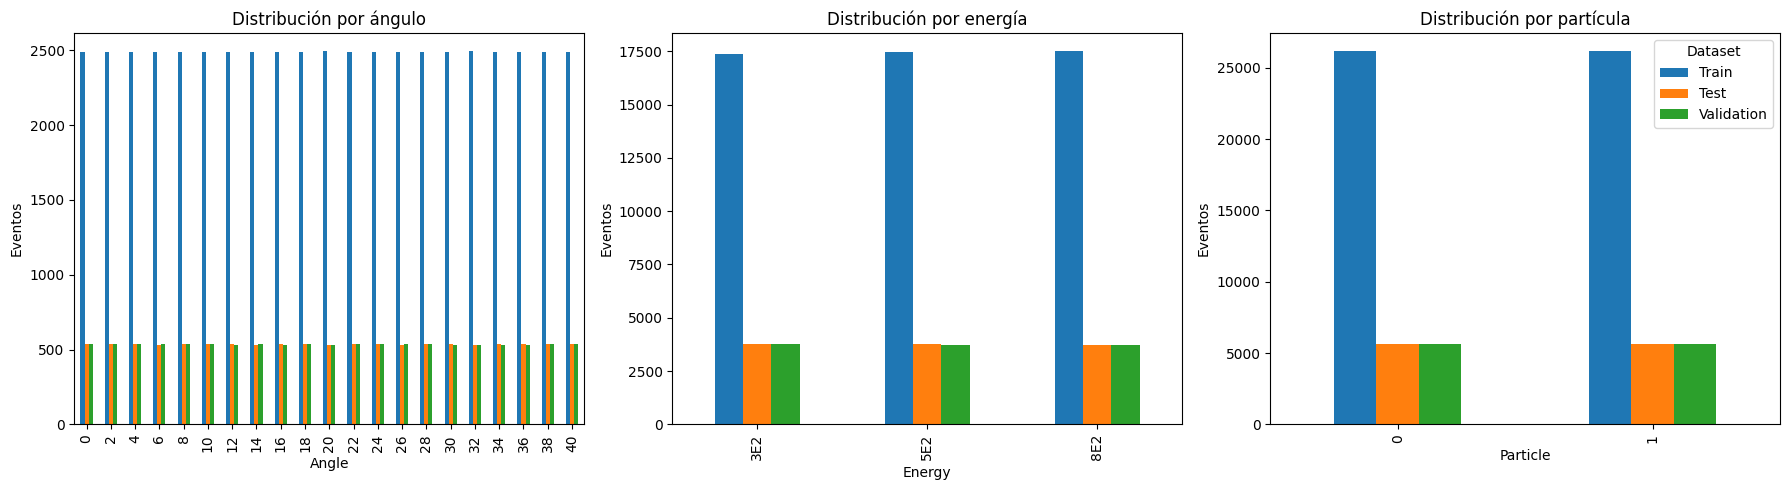

In [14]:
datasets = [
    ("Train", y_angle_train, y_energy_train, y_label_train),
    ("Validation", y_angle_val, y_energy_val, y_label_val),
    ("Test", y_angle_test, y_energy_test, y_label_test),
]

frames = []
for name, angle_arr, energy_arr, particle_arr in datasets:
    frames.append(
        pd.DataFrame(
            {
                "dataset": name,
                "angle": angle_arr.astype(int),
                "energy": energy_arr,
                "particle": particle_arr.astype(int),
            }
        )
    )

dist_df = pd.concat(frames, ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plots = [
    ("angle", "Distribución por ángulo"),
    ("energy", "Distribución por energía"),
    ("particle", "Distribución por partícula"),
]

order = ["Train", "Test", "Validation"]

for i, (ax, (feature, title)) in enumerate(zip(axes, plots)):
    counts = (
        dist_df.groupby(["dataset", feature])
        .size()
        .unstack("dataset", fill_value=0)
        .sort_index()
    )
    counts = counts[order]  # Reordenar columnas
    counts.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Eventos")
    if i == 2:
        ax.legend(title="Dataset")
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

In [15]:
# Crear una lista con los nombres de los sets
sets = ["Train", "Validation", "Test"]

# Crear una lista con las combinaciones energía-tipo
energy_types = []
for energy in energy_levels:
    for label in [0, 1]:
        tipo = "Photon" if label == 0 else "Proton"
        energy_types.append(f"{energy}-{tipo}")

# Inicializar el diccionario de conteos
table_dict = {set_name: [] for set_name in sets}
totals = []

for set_name, angle_arr, energy_arr, label_arr in datasets:
    row = []
    for energy in energy_levels:
        for label in [0, 1]:
            count = ((energy_arr == energy) & (label_arr == label)).sum()
            row.append(count)
    total = sum(row)
    table_dict[set_name] = row + [total]
    totals.append(total)

# Construir el DataFrame
columns = energy_types + ["Total"]
tabla = pd.DataFrame([table_dict[set_name] for set_name in sets], columns=columns, index=sets)
display(tabla)

,3E2-Photon,3E2-Proton,5E2-Photon,5E2-Proton,8E2-Photon,8E2-Proton,Total
Train,8678,8684,8728,8718,8745,8749,52302
Validation,1892,1894,1838,1875,1872,1836,11207
Test,1883,1875,1887,1860,1836,1868,11209


In [115]:
from tensorflow.keras.metrics import Metric

# ----------------------------- #
# Definición del modelo         #
# ----------------------------- #
def build_multitask_model(sequence_shape: tuple[int, int], global_dim: int, include_attention_outputs: bool = True) -> Model:
    seq_input = Input(shape=sequence_shape, name="seq_input")
    global_input = Input(shape=(global_dim,), name="global_input")

    x_cnn = layers.Masking(mask_value=0.0, name="masking")(seq_input)
    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_0")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_0")(x_cnn)

    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_1")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_1")(x_cnn)

    x_cnn = layers.Conv1D(128, 7, padding="same", activation="elu", name="conv_2")(x_cnn)
    x_cnn = layers.BatchNormalization(name="bn_2")(x_cnn)
    x_cnn = layers.MaxPooling1D(pool_size=2, padding="same", name="pool_2")(x_cnn)

    x_cnn = layers.Dense(128, activation="elu", name="dense_after_cnn1")(x_cnn)
    x_cnn = layers.Dense(256, activation="elu", name="dense_after_cnn2")(x_cnn)
    x_cnn = layers.Dropout(0.40, name="dropout_after_cnn")(x_cnn)
    x_cnn = layers.Dense(128, activation="elu", name="dense_after_cnn4")(x_cnn)

    attention_recorders = []
    attention_tap_names = {}

    def transformer_block(x: tf.Tensor, prefix: str) -> tuple[tf.Tensor, tf.Tensor]:
        x_norm = layers.LayerNormalization(name=f"pre_mha_norm_{prefix}")(x)
        mha_layer = layers.MultiHeadAttention(num_heads=1, key_dim=32, name=f"mha_{prefix}")
        attn_output, attn_scores = mha_layer(x_norm, x_norm, return_attention_scores=True)
        recorder = layers.Lambda(lambda s: s, name=f"attention_scores_{prefix}")(attn_scores)
        attention_tap_names[f"{prefix}_raw"] = recorder.name
        attention_recorders.append(recorder)
        x_add = layers.Add(name=f"add_{prefix}")([x, attn_output])
        x_norm_ffn = layers.LayerNormalization(name=f"pre_ffn_norm_{prefix}")(x_add)
        ffn = layers.Dense(128, activation="elu", name=f"ffn_dense_{prefix}1")(x_norm_ffn)
        ffn = layers.Dense(x.shape[-1], name=f"ffn_dense_{prefix}2")(ffn)
        x_out = layers.Add(name=f"ffn_add_{prefix}")([x_add, ffn])
        pooled = layers.GlobalAveragePooling1D(name=f"temporal_pooling_{prefix}")(x_out)
        return pooled, recorder

    feat_angle, attn_angle = transformer_block(x_cnn, "angle")
    feat_particle, attn_class = transformer_block(x_cnn, "class")
    feat_energy, attn_energy = transformer_block(x_cnn, "energy")

    merged_angle = layers.Concatenate(name="merge_angle")([feat_angle, global_input])
    merged_particle = layers.Concatenate(name="merge_particle")([feat_particle, global_input])
    merged_energy = layers.Concatenate(name="merge_energy")([feat_energy, global_input])

    class_branch = layers.Dropout(0.35, name="dropout_particle")(merged_particle)
    class_branch = layers.Dense(128, activation="elu", name="dense_particle")(class_branch)
    particle_out = layers.Dense(1, activation="sigmoid", dtype="float32", name="particle_output")(class_branch)

    angle_branch = layers.Dense(128, activation="elu", name="dense_angle")(merged_angle)
    angle_out = layers.Dense(1, activation="linear", dtype="float32", name="angle_output")(angle_branch)

    energy_branch = layers.Dense(128, activation="elu", name="dense_energy")(merged_energy)
    energy_branch = layers.Dropout(0.50, name="dropout_energy")(energy_branch)
    energy_out = layers.Dense(1, activation="linear", dtype="float32", name="energy_output")(energy_branch)

    # Crear modelo con o sin outputs de atención
    outputs = [particle_out, angle_out, energy_out]
    if include_attention_outputs:
        outputs.extend([attn_class, attn_angle, attn_energy])
    
    model = Model(inputs=[seq_input, global_input], outputs=outputs, name="CONDOR_Multitask")
    optimizer = optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

    model.attention_recorders = {
        logical: model.get_layer(layer_name)
        for logical, layer_name in attention_tap_names.items()
        if layer_name in [layer.name for layer in model.layers]
    }
    model.attention_layer_names = attention_tap_names

    class F1Score(Metric):
        def __init__(self, name="f1_score", threshold=0.5, **kwargs):
            super().__init__(name=name, **kwargs)
            self.threshold = threshold
            self.tp = self.add_weight(name="tp", initializer="zeros")
            self.fp = self.add_weight(name="fp", initializer="zeros")
            self.fn = self.add_weight(name="fn", initializer="zeros")

        def update_state(self, y_true, y_pred, sample_weight=None):
            y_pred = tf.cast(y_pred > self.threshold, tf.float32)
            y_true = tf.cast(y_true, tf.float32)
            tp = tf.reduce_sum(y_true * y_pred)
            fp = tf.reduce_sum((1 - y_true) * y_pred)
            fn = tf.reduce_sum(y_true * (1 - y_pred))
            self.tp.assign_add(tp)
            self.fp.assign_add(fp)
            self.fn.assign_add(fn)

        def result(self):
            precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
            recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
            return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        def reset_state(self):
            self.tp.assign(0)
            self.fp.assign(0)
            self.fn.assign(0)

    # Solo compilar con las primeras 3 salidas (predicciones)
    model.compile(
        optimizer=optimizer,
        loss={
            "particle_output": "binary_crossentropy",
            "angle_output": tf.keras.losses.Huber(),
            "energy_output": tf.keras.losses.Huber(),
        },
        loss_weights={
            "particle_output": 0.6,
            "angle_output": 1.0,
            "energy_output": 1.5,
        },
        metrics={
            "particle_output": [F1Score(name="f1_score")],
            "angle_output": "mae",
            "energy_output": "mae",
        },
    )
    return model

model = build_multitask_model(sequence_shape=(max_sequence_length, len(FEATURE_NAMES)), global_dim=Xg_train.shape[1])
model.summary()

Model: "CONDOR_Multitask"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 472, 6)]     0           []                               
                                                                                                  
 masking (Masking)              (None, 472, 6)       0           ['seq_input[0][0]']              
                                                                                                  
 conv_0 (Conv1D)                (None, 472, 128)     5504        ['masking[0][0]']                
                                                                                                  
 bn_0 (BatchNormalization)      (None, 472, 128)     512         ['conv_0[0][0]']                 
                                                                                   

In [55]:
# ----------------------------- #
# Entrenamiento                 #
# ----------------------------- #
callbacks_list = [
    callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, verbose=1, min_lr=1e-6),
]

history = model.fit(
    x=[X_train, Xg_train],
    y=[y_label_train, y_angle_train, y_energy_train_scaled],
    validation_data=([X_val, Xg_val], [y_label_val, y_angle_val, y_energy_val_scaled]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1,
)

model_dir = ARTIFACTS_DIR / "model"
model_dir.mkdir(parents=True, exist_ok=True)
model_path = model_dir / "condor_multitask_model.keras"
model.save(model_path)
print(f"Modelo guardado en: {model_path}")

Epoch 1/100
1635/1635 [==============================] - 188s 107ms/step - loss: 4.2268 - particle_output_loss: 0.5156 - angle_output_loss: 2.0602 - energy_output_loss: 1.2382 - particle_output_f1_score: 0.7785 - angle_output_mae: 2.5089 - energy_output_mae: 1.6444 - val_loss: 2.4249 - val_particle_output_loss: 0.2804 - val_angle_output_loss: 1.6475 - val_energy_output_loss: 0.4061 - val_particle_output_f1_score: 0.8902 - val_angle_output_mae: 2.0906 - val_energy_output_mae: 0.7828 - lr: 5.0000e-04
Epoch 2/100
1635/1635 [==============================] - 148s 91ms/step - loss: 2.0497 - particle_output_loss: 0.3421 - angle_output_loss: 1.2041 - energy_output_loss: 0.4269 - particle_output_f1_score: 0.8635 - angle_output_mae: 1.6323 - energy_output_mae: 0.8042 - val_loss: 2.6059 - val_particle_output_loss: 0.2206 - val_angle_output_loss: 1.8686 - val_energy_output_loss: 0.4033 - val_particle_output_f1_score: 0.9184 - val_angle_output_mae: 2.3089 - val_energy_output_mae: 0.7752 - lr: 5.00

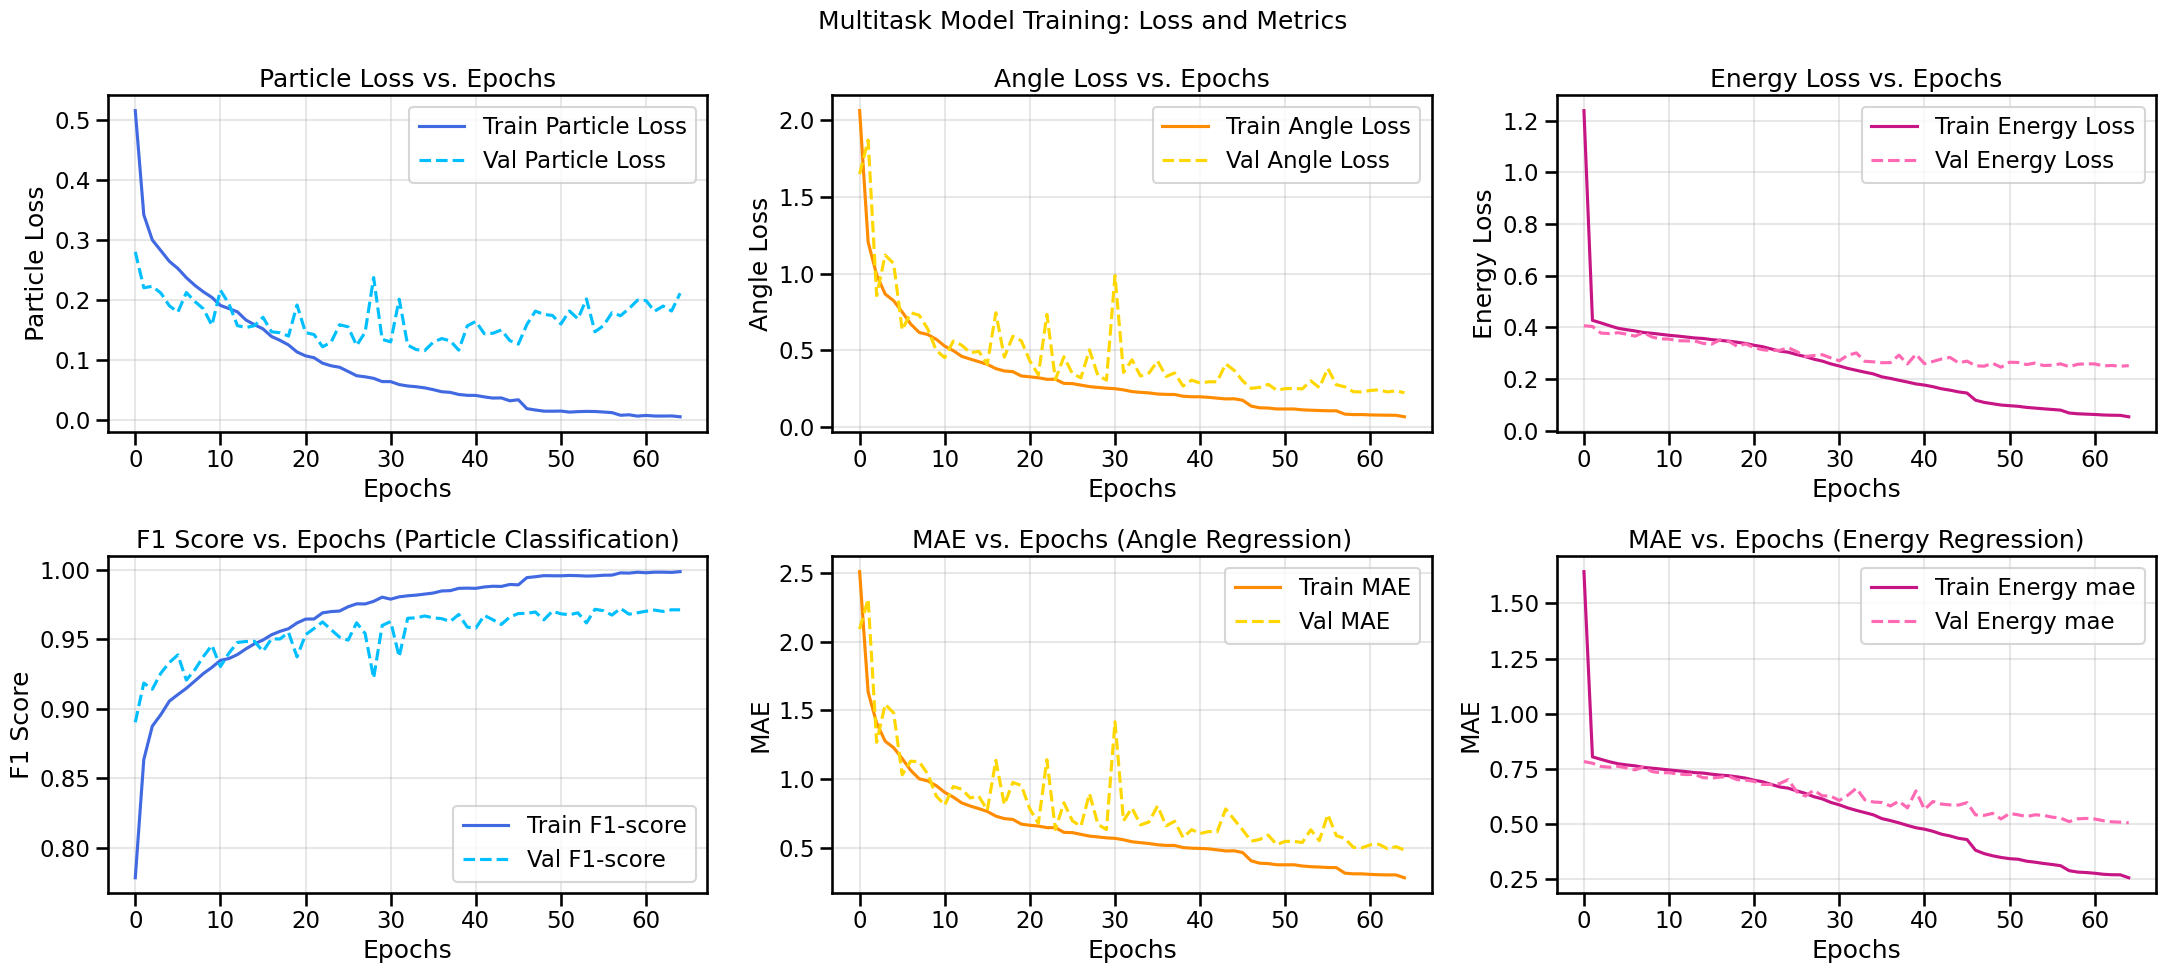

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))

# 1a. Particle Loss
axes[0, 0].plot(history.history['particle_output_loss'], label='Train Particle Loss', color='royalblue')
axes[0, 0].plot(history.history['val_particle_output_loss'], label='Val Particle Loss', color='deepskyblue', linestyle='--')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Particle Loss')
axes[0, 0].set_title('Particle Loss vs. Epochs')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 1b. Angle Loss
axes[0, 1].plot(history.history['angle_output_loss'], label='Train Angle Loss', color='darkorange')
axes[0, 1].plot(history.history['val_angle_output_loss'], label='Val Angle Loss', color='gold', linestyle='--')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Angle Loss')
axes[0, 1].set_title('Angle Loss vs. Epochs')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 1c. Energy Loss
axes[0, 2].plot(history.history['energy_output_loss'], label='Train Energy Loss', color='mediumvioletred')
axes[0, 2].plot(history.history['val_energy_output_loss'], label='Val Energy Loss', color='hotpink', linestyle='--')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Energy Loss')
axes[0, 2].set_title('Energy Loss vs. Epochs')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 2a. Particle Accuracy
axes[1, 0].plot(history.history['particle_output_f1_score'], label='Train F1-score', color='royalblue')
axes[1, 0].plot(history.history['val_particle_output_f1_score'], label='Val F1-score', color='deepskyblue', linestyle='--')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score vs. Epochs (Particle Classification)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 2b. Angle MAE
axes[1, 1].plot(history.history['angle_output_mae'], label='Train MAE', color='darkorange')
axes[1, 1].plot(history.history['val_angle_output_mae'], label='Val MAE', color='gold', linestyle='--')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_title('MAE vs. Epochs (Angle Regression)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 2c. Energy Accuracy
axes[1, 2].plot(history.history['energy_output_mae'], label='Train Energy mae', color='mediumvioletred')
axes[1, 2].plot(history.history['val_energy_output_mae'], label='Val Energy mae', color='hotpink', linestyle='--')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].set_title('MAE vs. Epochs (Energy Regression)')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.suptitle('Multitask Model Training: Loss and Metrics', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(model_dir, "training_multitask_metrics.png"), dpi=200)
plt.show()

In [61]:
def attach_attention_recorders(m):
    tap_names = {
        "angle_raw": "attention_scores_angle",
        "particle_raw": "attention_scores_class",
        "energy_raw": "attention_scores_energy",
    }
    m.attention_layer_names = tap_names
    m.attention_recorders = {
        logical: m.get_layer(layer_name)
        for logical, layer_name in tap_names.items()
        if any(layer.name == layer_name for layer in m.layers)
    }

use_in_memory_model = "model" in globals() and model is not None and "history" in globals()

if use_in_memory_model:
    print("Modelo en memoria detectado; se mantiene el modelo entrenado en esta sesión.")
    attach_attention_recorders(model)
else:
    if not model_path.exists():
        raise FileNotFoundError(f"No se encontró el modelo en {model_path}")
    if "F1Score" not in globals():
        class F1Score(tf.keras.metrics.Metric):
            def __init__(self, name="f1_score", threshold=0.5, **kwargs):
                super().__init__(name=name, **kwargs)
                self.threshold = threshold
                self.tp = self.add_weight("tp", initializer="zeros")
                self.fp = self.add_weight("fp", initializer="zeros")
                self.fn = self.add_weight("fn", initializer="zeros")

            def update_state(self, y_true, y_pred, sample_weight=None):
                y_pred = tf.cast(y_pred > self.threshold, tf.float32)
                y_true = tf.cast(y_true, tf.float32)
                self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
                self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
                self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

            def result(self):
                precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
                recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
                return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

            def reset_state(self):
                for var in (self.tp, self.fp, self.fn):
                    var.assign(0.0)

    model = tf.keras.models.load_model(
        model_path,
        custom_objects={"F1Score": F1Score},
    )
    attach_attention_recorders(model)
    print(f"Modelo cargado desde: {model_path}")

Modelo en memoria detectado; se mantiene el modelo entrenado en esta sesión.


In [60]:
# ----------------------------- #
# Evaluación numérica básica    #
# ----------------------------- #
eval_results = model.evaluate(
    x=[X_test, Xg_test],
    y=[y_label_test, y_angle_test, y_energy_test_scaled],
    verbose=1,
)
metrics_names = model.metrics_names
eval_dict = {name: float(value) for name, value in zip(metrics_names, eval_results)}

pred_particle, pred_angle, pred_energy_scaled = model.predict([X_test, Xg_test], batch_size=256, verbose=1)
pred_particle = pred_particle.reshape(-1)
pred_angle = pred_angle.reshape(-1)
pred_energy_scaled = pred_energy_scaled.reshape(-1)
pred_energy_cont = pred_energy_scaled * energy_std + energy_mean

pred_particle_labels = (pred_particle >= 0.5).astype(np.int32)
particle_accuracy = float(np.mean(pred_particle_labels == y_label_test))
angle_mae = float(np.mean(np.abs(pred_angle - y_angle_test)))
energy_mae = float(np.mean(np.abs(pred_energy_cont - y_energy_test_cont)))
energy_rmse = float(np.sqrt(np.mean((pred_energy_cont - y_energy_test_cont) ** 2)))

additional_metrics = {
    "particle_accuracy_custom": particle_accuracy,
    "angle_mae_deg_custom": angle_mae,
    "energy_mae_GeV_custom": energy_mae,
    "energy_rmse_GeV_custom": energy_rmse,
}

44/44 [==============================] - 3s 78ms/step


In [ ]:
# ----------------------------- #
# Persistencia de artefactos    #
# ----------------------------- #

# Persistir metadatos de atención para reconstruir los taps al recargar
default_attention_map = {
    "angle_raw": "attention_scores_angle",
    "particle_raw": "attention_scores_class",
    "energy_raw": "attention_scores_energy",
}
attention_map = getattr(model, "attention_layer_names", None) or default_attention_map
attention_json = model_dir / "attention_layers.json"
with attention_json.open("w", encoding="utf-8") as fh:
    json.dump(attention_map, fh, indent=2)
print(f"Mapeo de capas de atención guardado en: {attention_json}")

history_df = pd.DataFrame(history.history)
history_csv = model_dir / "training_history.csv"
history_df.to_csv(history_csv, index=False)
print(f"Historial de entrenamiento guardado en: {history_csv}")

metrics_path = model_dir / "evaluation_metrics.json"
with metrics_path.open("w", encoding="utf-8") as fh:
    json.dump(
        {"keras_metrics": eval_dict, "custom_metrics": additional_metrics},
        fh,
        indent=2,
    )
print(f"Métricas básicas guardadas en: {metrics_path}")

pred_npz_path = ARTIFACTS_DIR / "test_predictions.npz"
np.savez_compressed(
    pred_npz_path,
    particle_probability=pred_particle.astype(np.float32),
    particle_label_pred=pred_particle_labels,
    particle_label_true=y_label_test,
    angle_pred=pred_angle.astype(np.float32),
    angle_true=y_angle_test,
    energy_pred_scaled=pred_energy_scaled.astype(np.float32),
    energy_pred=pred_energy_cont.astype(np.float32),
    energy_true=y_energy_test_cont,
    energy_true_str=np.array(y_energy_test, dtype="<U8"),
    energy_levels=np.array(energy_levels, dtype="<U8"),
    energy_mean=np.array([energy_mean], dtype=np.float32),
    energy_std=np.array([energy_std], dtype=np.float32),
)
print(f"Predicciones de test guardadas en: {pred_npz_path}")

Mapeo de capas de atención guardado en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\model\attention_layers.json
Historial de entrenamiento guardado en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\model\training_history.csv
Métricas básicas guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\model\evaluation_metrics.json
Predicciones de test guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\test_predictions.npz


In [64]:
metadata = {
    "seed": SEED,
    "energies_used": list(ENERGY_FILTER),
    "angle_max_deg": ANGLE_MAX,
    "min_total_particles": MIN_TOTAL_PARTICLES,
    "balance_target_per_group": target_per_group,
    "num_events_total": int(len(df_balanced)),
    "train_val_test_split": {
        "train": int(len(train_idx)),
        "val": int(len(val_idx)),
        "test": int(len(test_idx)),
    },
    "feature_order": FEATURE_NAMES,
    "max_sequence_length": max_sequence_length,
    "global_features_definition": [
        "sum_particle_count",
        "sum_total_energy",
        "num_active_detectors",
        "duration_tbin",
        "sum_total_energy_central_ids",
    ],
    "central_detector_ids": [int(x) for x in central_ids],
    "energy_scaling": {"mean": energy_mean, "std": energy_std},
    "artifacts": {
        "dataset_npz": str(pred_npz_path),
        "history_csv": str(history_csv),
        "model_path": str(model_path),
        "metrics_path": str(metrics_path),
        "predictions_npz": str(pred_npz_path),
        "detector_catalog_csv": str(ARTIFACTS_DIR / "detector_catalog.csv"),
    },
    "keras_metrics": eval_dict,
    "custom_metrics": additional_metrics,
}

metadata_path = ARTIFACTS_DIR / "preprocessing_metadata.json"
with metadata_path.open("w", encoding="utf-8") as fh:
    json.dump(metadata, fh, indent=2)
print(f"Metadata guardada en: {metadata_path}")

Metadata guardada en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\preprocessing_metadata.json


In [69]:
# ----------------------------- #
# Visualización de predicciones #
# ----------------------------- #
sns.set_context("poster")
sns.set_style("ticks")
plots_dir = ARTIFACTS_DIR / "diagnostics"
plots_dir.mkdir(parents=True, exist_ok=True)

pred_summary = pd.DataFrame(
    {
        "particle_true": y_label_test.astype(int),
        "particle_pred_prob": pred_particle.astype(float),
        "particle_pred_label": pred_particle_labels.astype(int),
        "angle_true_deg": y_angle_test.astype(float),
        "angle_pred_deg": pred_angle.astype(float),
        "energy_true_GeV": y_energy_test_cont.astype(float),
        "energy_pred_GeV": pred_energy_cont.astype(float),
        "energy_level_true": y_energy_test,
    }
)
pred_summary["angle_error_deg"] = pred_summary["angle_pred_deg"] - pred_summary["angle_true_deg"]
pred_summary["energy_error_GeV"] = pred_summary["energy_pred_GeV"] - pred_summary["energy_true_GeV"]
pred_summary["particle_correct"] = pred_summary["particle_pred_label"] == pred_summary["particle_true"]
pred_summary["angle_abs_error_deg"] = pred_summary["angle_error_deg"].abs()
pred_summary["energy_abs_error_GeV"] = pred_summary["energy_error_GeV"].abs()

angle_metrics = {
    "MAE (deg)": mean_absolute_error(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
    "RMSE (deg)": root_mean_squared_error(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
    "R2": r2_score(pred_summary["angle_true_deg"], pred_summary["angle_pred_deg"]),
}
energy_metrics = {
    "MAE (GeV)": mean_absolute_error(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
    "RMSE (GeV)": root_mean_squared_error(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
    "R2": r2_score(pred_summary["energy_true_GeV"], pred_summary["energy_pred_GeV"]),
}

display(pd.DataFrame(angle_metrics, index=["Ángulo"]).T.round(4))
display(pd.DataFrame(energy_metrics, index=["Energía"]).T.round(4))

,Ángulo
MAE (deg),0.5282
RMSE (deg),0.7985
R2,0.9957


,Energía
MAE (GeV),105.5452
RMSE (GeV),152.0708
R2,0.4510


## Gamma-Hadron Discrimination results

,precision,recall,f1-score,support
Proton,0.9788,0.9613,0.9699,5606.0000
Photon,0.9619,0.9791,0.9705,5603.0000
accuracy,0.9702,0.9702,0.9702,0.9702
macro avg,0.9704,0.9702,0.9702,11209.0000
weighted avg,0.9704,0.9702,0.9702,11209.0000


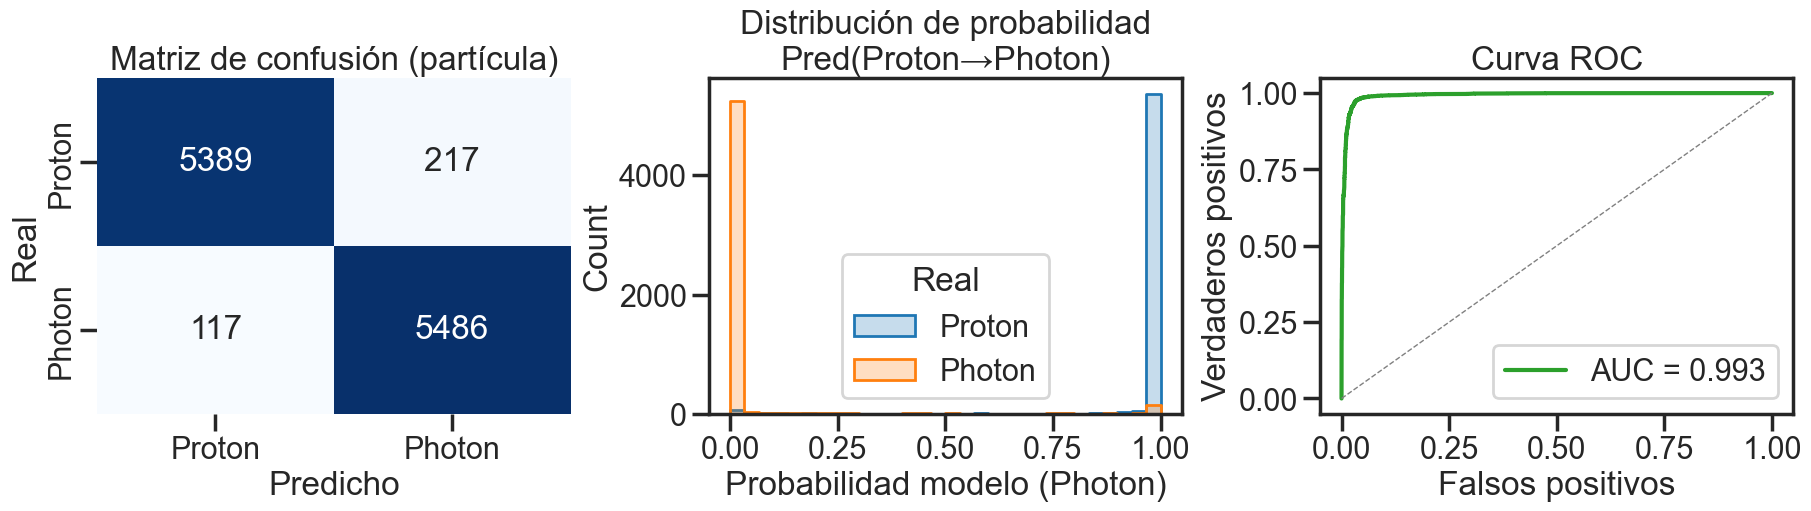

In [70]:
# ----------------------------- #
# Diagnóstico de clasificación de partícula #
# ----------------------------- #
cm_particle = confusion_matrix(pred_summary["particle_true"], pred_summary["particle_pred_label"])
particle_report = classification_report(
    pred_summary["particle_true"],
    pred_summary["particle_pred_label"],
    target_names=["Proton", "Photon"],
    output_dict=True,
)
display(pd.DataFrame(particle_report).T.round(4))

fpr, tpr, _ = roc_curve(pred_summary["particle_true"], pred_summary["particle_pred_prob"])
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

sns.heatmap(cm_particle, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Real")
axes[0].set_title("Matriz de confusión (partícula)")
axes[0].set_xticklabels(["Proton", "Photon"])
axes[0].set_yticklabels(["Proton", "Photon"])

sns.histplot(
    data=pred_summary,
    x="particle_pred_prob",
    hue="particle_true",
    bins=30,
    element="step",
    common_norm=False,
    palette={0: "tab:orange", 1: "tab:blue"},
    ax=axes[1],
)
axes[1].set_title("Distribución de probabilidad\nPred(Proton→Photon)")
axes[1].set_xlabel("Probabilidad modelo (Photon)")
axes[1].legend(title="Real", labels=["Proton", "Photon"])

axes[2].plot(fpr, tpr, color="tab:green", label=f"AUC = {roc_auc:.3f}")
axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
axes[2].set_xlabel("Falsos positivos")
axes[2].set_ylabel("Verdaderos positivos")
axes[2].set_title("Curva ROC")
axes[2].legend(loc="lower right")

fig.savefig(plots_dir / "particle_predictions_overview.png", dpi=200)
plt.show()

## Zenith Angle Reconstruction results

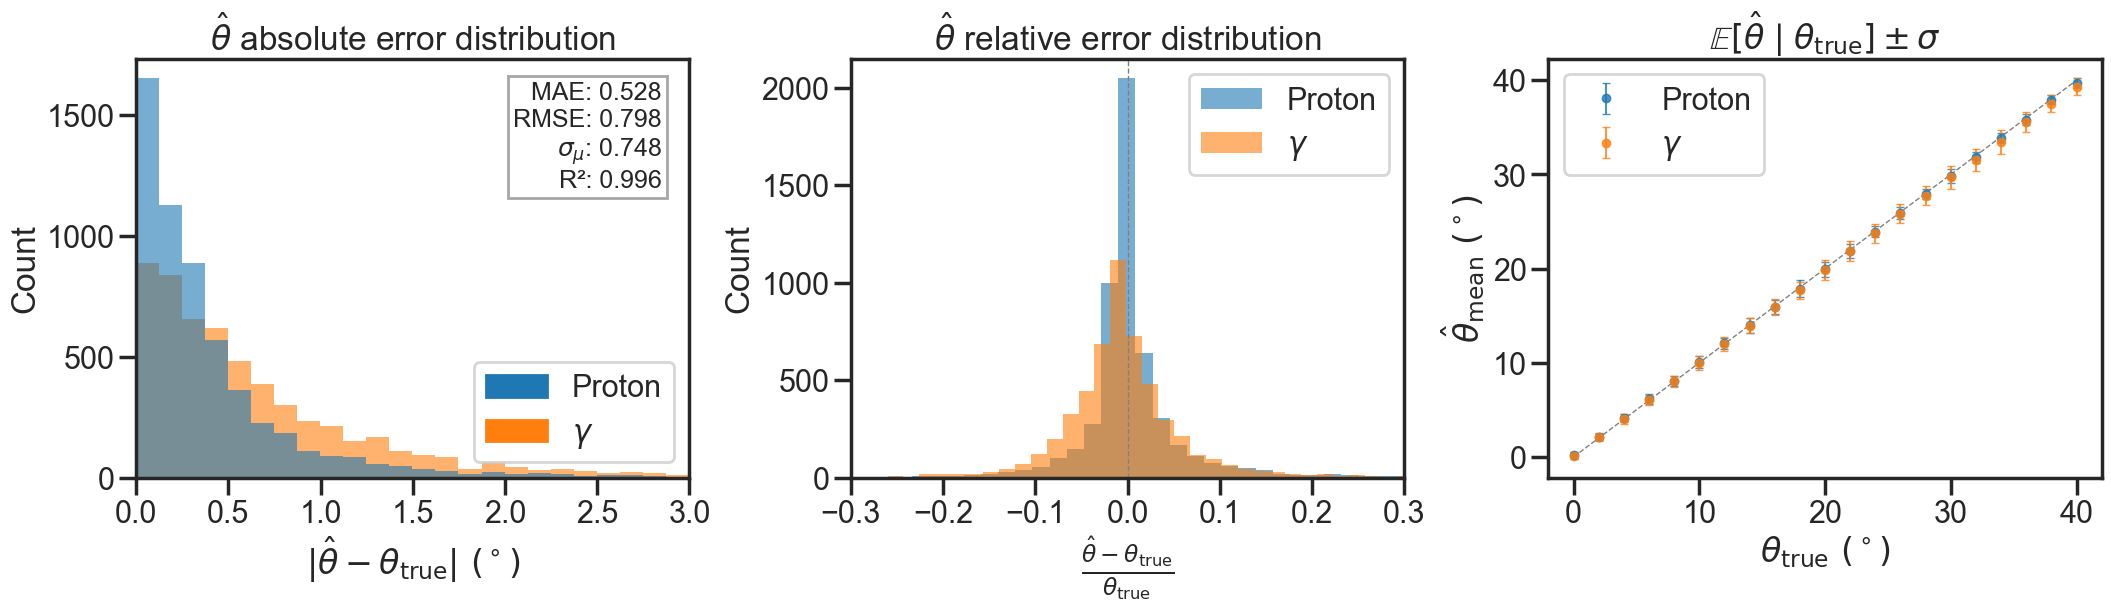

In [75]:
from matplotlib.patches import Patch

# ----------------------------- #
# Diagnóstico de ángulo y energía (por partícula) #
# ----------------------------- #
theta_hat = pred_summary["angle_pred_deg"]
theta_true = pred_summary["angle_true_deg"]
particle_series = pred_summary["particle_true"]

particle_names = {0: "Proton", 1: r"$\gamma$"}
particle_palette = {0: "tab:blue", 1: "tab:orange"}

denom = theta_true.replace(0.0, np.nan)
theta_rel_error = (theta_hat - theta_true) / denom
theta_rel_error = theta_rel_error.replace([np.inf, -np.inf], np.nan)

angle_bins = np.round(theta_true, 1)
angle_group = (
    pred_summary.assign(angle_bin=angle_bins)
    .groupby("angle_bin")
    .agg(mean_pred=("angle_pred_deg", "mean"), std_pred=("angle_pred_deg", "std"))
    .reset_index()
)
angle_group_particle = (
    pred_summary.assign(angle_bin=angle_bins)
    .groupby(["particle_true", "angle_bin"])
    .agg(mean_pred=("angle_pred_deg", "mean"), std_pred=("angle_pred_deg", "std"))
    .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

sns.histplot(
    pred_summary,
    x="angle_abs_error_deg",
    hue="particle_true",
    bins=60,
    ax=axes[0],
    edgecolor="none",
    alpha=0.6,
    palette=particle_palette,
)
axes[0].set_xlabel(r"$|\hat{\theta} - \theta_{\mathrm{true}}|\ (^\circ)$")
axes[0].set_title(r"$\hat{\theta}$ absolute error distribution")
axes[0].legend(handles=[
    Patch(color=particle_palette[pid], label=particle_names[pid]) for pid in particle_palette
])
axes[0].set_xlim(0.0, 3.0)

sigma_mu = angle_group["std_pred"].mean()
metrics_text = (
    f"MAE: {angle_metrics['MAE (deg)']:.3f}\n"
    f"RMSE: {angle_metrics['RMSE (deg)']:.3f}\n"
    f"$\\sigma_\\mu$: {sigma_mu:.3f}\n"
    f"R²: {angle_metrics['R2']:.3f}"
)
axes[0].text(
    0.95,
    0.68,
    metrics_text,
    transform=axes[0].transAxes,
    fontsize=18,
    va="bottom",
    ha="right",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"),
)

for pid, color in particle_palette.items():
    mask = particle_series == pid
    sns.histplot(
        theta_rel_error[mask].dropna(),
        bins=80,
        color=color,
        ax=axes[1],
        edgecolor="none",
        alpha=0.6,
        label=particle_names[pid],
    )
axes[1].axvline(0.0, color="gray", linestyle="--", linewidth=1)
axes[1].set_xlabel(r"$\frac{\hat{\theta}-\theta_{\mathrm{true}}}{\theta_{\mathrm{true}}}$")
axes[1].set_title(r"$\hat{\theta}$ relative error distribution")
axes[1].set_xlim(-0.3, 0.3)
axes[1].legend()

for pid, color in particle_palette.items():
    subset = angle_group_particle[angle_group_particle["particle_true"] == pid]
    axes[2].errorbar(
        subset["angle_bin"],
        subset["mean_pred"],
        yerr=subset["std_pred"].fillna(0.0),
        fmt=".",
        color=color,
        ecolor=color,
        elinewidth=1.5,
        alpha=0.8,
        capsize=3,
        label=particle_names[pid],
    )
axes[2].plot(
    angle_group["angle_bin"],
    angle_group["angle_bin"],
    color="gray",
    linestyle="--",
    linewidth=1,
)
axes[2].set_xlabel(r"$\theta_{\mathrm{true}}\ (^\circ)$")
axes[2].set_ylabel(r"$\hat{\theta}_{\mathrm{mean}}\ (^\circ)$")
axes[2].set_title(r"$\mathbb{E}[\hat{\theta}\mid\theta_{\mathrm{true}}] \pm \sigma$")
axes[2].legend()
fig.savefig(plots_dir / "angle_predictions_overview.png", dpi=200)
plt.show()



## Energy Estimation results

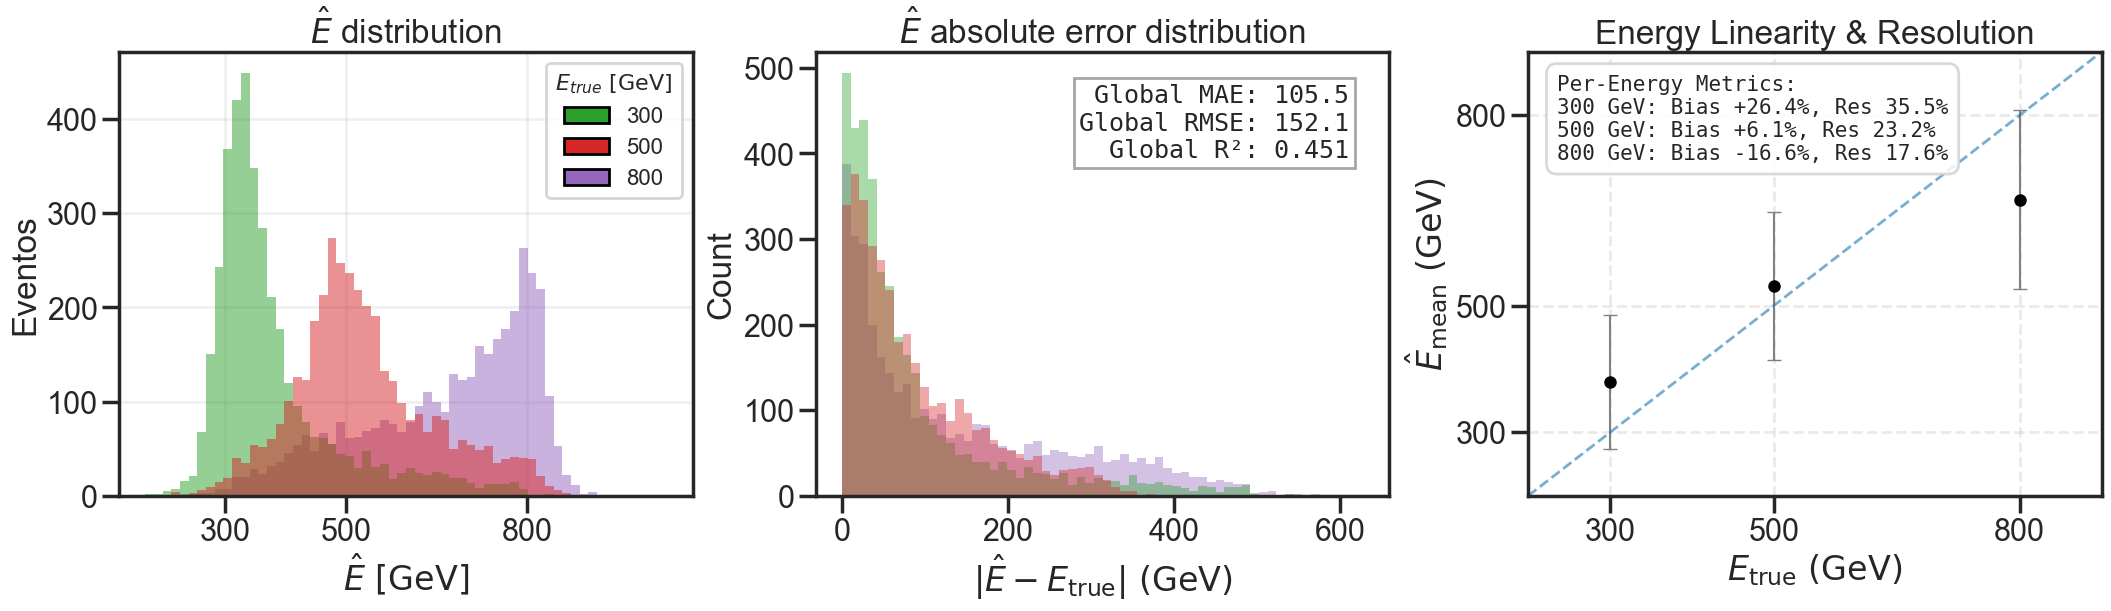

In [97]:
E_hat = pred_summary["energy_pred_GeV"]
E_true = pred_summary["energy_true_GeV"]

# Cálculo de error relativo global para uso interno
# Bias = (Pred - True) / True
rel_error_series = (E_hat - E_true) / E_true.replace(0.0, np.nan)
pred_summary["relative_error"] = rel_error_series # Lo guardamos en el DF para facilitar el groupby

energy_group = (
    pred_summary.groupby("energy_true_GeV")
    .agg(mean_pred=("energy_pred_GeV", "mean"), std_pred=("energy_pred_GeV", "std"))
    .reset_index()
)

energy_group_level = (
    pred_summary.groupby("energy_level_true")
    .agg(
        mean_pred=("energy_pred_GeV", "mean"),
        std_pred=("energy_pred_GeV", "std"),
        true_energy=("energy_true_GeV", "mean"),
    )
    .reset_index()
    .sort_values("true_energy")
)

energy_palette = {"3E2": "tab:green", "5E2": "tab:red", "8E2": "tab:purple"}
label_map = {"3E2": "300", "5E2": "500", "8E2": "800"}
desired_order = ["300", "500", "800"]

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

# --- AXES 0: Distribución de Predicciones ---
sns.histplot(
    data=pred_summary,
    x="energy_pred_GeV",
    hue="energy_level_true",
    bins=60,
    ax=axes[0],
    alpha=0.5,
    edgecolor="none",
    palette=energy_palette,
    multiple="layer",
)
axes[0].set_xlabel(r"$\hat{E}\ \mathrm{[GeV]}$")
axes[0].set_ylabel("Eventos")
axes[0].set_title(r"$\hat{E}$ distribution")
axes[0].set_xticks([300, 500, 800])
axes[0].grid(alpha=0.3)

# Leyenda ordenada para Axes 0
handles0, labels0 = axes[0].get_legend_handles_labels()
if handles0:
    mapped = []
    for h, lab in zip(handles0, labels0):
        mapped_label = label_map.get(lab, lab)
        mapped.append((mapped_label, h))
    in_order = [item for item in mapped if item[0] in desired_order]
    out_order = [item for item in mapped if item[0] not in desired_order]
    in_order_sorted = sorted(in_order, key=lambda x: desired_order.index(x[0]))
    new_handles = [h for lbl, h in (in_order_sorted + out_order)]
    new_labels = [lbl for lbl, h in (in_order_sorted + out_order)]
    axes[0].legend(new_handles, new_labels, title=r"$E_{true}\ \mathrm{[GeV]}$")
else:
    manual_handles = []
    manual_labels = []
    for key in ["3E2", "5E2", "8E2"]:
        if (pred_summary["energy_level_true"] == key).any():
            manual_handles.append(Patch(facecolor=energy_palette[key], edgecolor="k"))
            manual_labels.append(label_map[key])
    if manual_handles:
        axes[0].legend(manual_handles, manual_labels, title=r"$E_{true}\ \mathrm{[GeV]}$", fontsize=16, title_fontsize=16)

# --- AXES 1: Error Absoluto ---
sns.histplot(
    pred_summary,
    x="energy_abs_error_GeV",
    hue="energy_level_true",
    bins=60,
    ax=axes[1],
    alpha=0.4,
    edgecolor="none",
    palette=energy_palette,
)
axes[1].set_xlabel(r"$|\hat{E} - E_{\mathrm{true}}|\ (\mathrm{GeV})$")
axes[1].set_title(r"$\hat{E}$ absolute error distribution")
leg1 = axes[1].get_legend()
if leg1:
    leg1.remove()

sigma_mu_E = energy_group["std_pred"].mean()
metrics_text_E = (
    f"Global MAE: {energy_metrics['MAE (GeV)']:.1f}\n"
    f"Global RMSE: {energy_metrics['RMSE (GeV)']:.1f}\n"
    f"Global R²: {energy_metrics['R2']:.3f}"
)
axes[1].text(
    0.93, 0.75, metrics_text_E,
    transform=axes[1].transAxes,
    fontsize=18,
    va="bottom",
    ha="right",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"),
    family="monospace"
)

# --- AXES 2: Linealidad con Bias y Resolución ---
axes[2].errorbar(
    energy_group_level["true_energy"],
    energy_group_level["mean_pred"],
    yerr=energy_group_level["std_pred"].fillna(0.0),
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=1.5,
    capsize=5,
    markersize=8
)
# Línea de identidad perfecta
axes[2].plot(
    [200, 900], [200, 900], # Rango extendido para que se vea bien la línea
    color="tab:blue",
    linestyle="--",
    linewidth=2,
    alpha=0.6,
    label="Ideal"
)

# --- CÁLCULO DE BIAS Y RESOLUCIÓN PARA EL CUADRO DE TEXTO ---
stats_text_lines = ["Per-Energy Metrics:"]
map_keys = [("3E2", "300"), ("5E2", "500"), ("8E2", "800")]

for key_df, label_display in map_keys:
    # Filtrar datos por nivel de energía
    subset = pred_summary[pred_summary["energy_level_true"] == key_df]
    
    if not subset.empty:
        # Bias: Media del error relativo (%)
        # Resolution: Desviación estándar del error relativo (%)
        rel_errs = subset["relative_error"]
        bias_pct = rel_errs.mean() * 100
        res_pct = rel_errs.std() * 100
        
        line = f"{label_display} GeV: Bias {bias_pct:+.1f}%, Res {res_pct:.1f}%"
        stats_text_lines.append(line)

final_stats_text = "\n".join(stats_text_lines)

# Insertar el cuadro de texto en Axes 2 (Esquina superior izquierda)
axes[2].text(
    0.05, 0.95, 
    final_stats_text,
    transform=axes[2].transAxes,
    fontsize=15,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="lightgray", boxstyle="round,pad=0.5"),
    family="monospace" # Fuente monoespaciada para que los números se alineen mejor
)

axes[2].set_xlabel(r"$E_{\mathrm{true}}\ (\mathrm{GeV})$")
axes[2].set_ylabel(r"$\hat{E}_{\mathrm{mean}}\ (\mathrm{GeV})$")
axes[2].set_title(r"Energy Linearity & Resolution")
axes[2].set_xticks([300, 500, 800])
axes[2].set_yticks([300, 500, 800])
axes[2].set_xlim(200, 900)
axes[2].set_ylim(200, 900)
axes[2].grid(True, linestyle="--", alpha=0.4)

# Guardar y mostrar
# fig.savefig(plots_dir / "energy_predictions_overview.png", dpi=200)
plt.show()

## Permutation Feature Importance (PFI)

In [104]:
# Permutation Feature Importance solo con features secuenciales
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_absolute_error

OUTPUT_SPECS = {
    "particle": {
        "metric_name": "accuracy",
        "metric": lambda pred: accuracy_score(y_label_test.astype(int), (pred >= 0.5).astype(int)),
        "higher_is_better": True,
    },
    "angle": {
        "metric_name": "MAE_deg",
        "metric": lambda pred: mean_absolute_error(y_angle_test.astype(float), pred.astype(float)),
        "higher_is_better": False,
    },
    "energy": {
        "metric_name": "MAE_GeV",
        "metric": lambda pred: mean_absolute_error(y_energy_test_cont.astype(float), pred.astype(float)),
        "higher_is_better": False,
    },
}

def _predict_all_heads(seq_input, global_input, batch_size=256):
    head_particle, head_angle, head_energy_scaled = model.predict(
        [seq_input, global_input], batch_size=batch_size, verbose=0
    )
    head_particle = head_particle.reshape(-1)
    head_angle = head_angle.reshape(-1)
    head_energy = head_energy_scaled.reshape(-1) * energy_std + energy_mean
    return {"particle": head_particle, "angle": head_angle, "energy": head_energy}

def _permute_sequence_feature(seq_data, feat_idx, rng):
    permuted = np.array(seq_data, copy=True)
    feature_view = permuted[:, :, feat_idx]
    for t_idx in range(feature_view.shape[1]):
        feature_view[:, t_idx] = rng.permutation(feature_view[:, t_idx])
    permuted[:, :, feat_idx] = feature_view
    return permuted

def compute_pfi_sequence_features(
    model,
    X_seq,
    X_global,
    *,
    n_repeats=8,
    random_state=42,
    batch_size=256,
):
    rng_master = np.random.default_rng(random_state)
    baseline_preds = _predict_all_heads(X_seq, X_global, batch_size=batch_size)
    baseline_scores = {
        task: spec["metric"](baseline_preds[task]) for task, spec in OUTPUT_SPECS.items()
    }

    records = []
    for feat_idx, feat_name in enumerate(FEATURE_NAMES):
        task_scores = {task: [] for task in OUTPUT_SPECS}
        for _ in range(n_repeats):
            rng = np.random.default_rng(rng_master.integers(0, 2**32 - 1))
            X_perm = _permute_sequence_feature(X_seq, feat_idx, rng)
            perm_preds = _predict_all_heads(X_perm, X_global, batch_size=batch_size)
            for task, spec in OUTPUT_SPECS.items():
                task_scores[task].append(spec["metric"](perm_preds[task]))

        for task, scores in task_scores.items():
            scores = np.asarray(scores, dtype=float)
            baseline = baseline_scores[task]
            mean_score = float(scores.mean())
            std_score = float(scores.std(ddof=1))
            delta = baseline - mean_score if OUTPUT_SPECS[task]["higher_is_better"] else mean_score - baseline
            records.append(
                {
                    "feature": f"sequence::{feat_name}",
                    "task": task,
                    "metric_name": OUTPUT_SPECS[task]["metric_name"],
                    "baseline": baseline,
                    "permuted_mean": mean_score,
                    "permuted_std": std_score,
                    "importance_delta": delta,
                }
            )

    results = (
        pd.DataFrame(records)
        .sort_values(["task", "importance_delta"], ascending=[True, False])
        .reset_index(drop=True)
    )
    return baseline_scores, results

baseline_scores, pfi_results = compute_pfi_sequence_features(
    model,
    X_test,
    Xg_test,
    n_repeats=8,
    random_state=42,
    batch_size=256,
)

print("Baseline metrics por head:")
for task, value in baseline_scores.items():
    print(f"  {task}: {value:.4f}")

display(pfi_results)
pfi_results.to_csv(ARTIFACTS_DIR / "diagnostics" / "pfi_all_heads_sequence_only.csv", index=False)

Baseline metrics por head:
  particle: 0.9702
  angle: 0.5282
  energy: 105.5452


,feature,task,metric_name,baseline,permuted_mean,permuted_std,importance_delta
0,sequence::t_bin,angle,MAE_deg,0.528162,17.754767,0.036571,17.226604
1,sequence::x_center,angle,MAE_deg,0.528162,16.165885,0.022192,15.637722
2,sequence::detector_id,angle,MAE_deg,0.528162,9.848590,0.029756,9.320428
3,sequence::y_center,angle,MAE_deg,0.528162,7.409324,0.015919,6.881162
4,sequence::total_energy,angle,MAE_deg,0.528162,1.424614,0.005125,0.896452
5,sequence::particle_count,angle,MAE_deg,0.528162,0.727205,0.002694,0.199043
6,sequence::t_bin,energy,MAE_GeV,105.545238,816.405673,0.666931,710.860436
7,sequence::detector_id,energy,MAE_GeV,105.545238,408.600180,0.448316,303.054943
8,sequence::x_center,energy,MAE_GeV,105.545238,384.817727,0.345694,279.272490
9,sequence::y_center,energy,MAE_GeV,105.545238,214.003001,0.576593,108.457763


C:\Users\Froxo\AppData\Local\Temp\ipykernel_27856\3754146337.py:48: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.28, wspace=0.25)


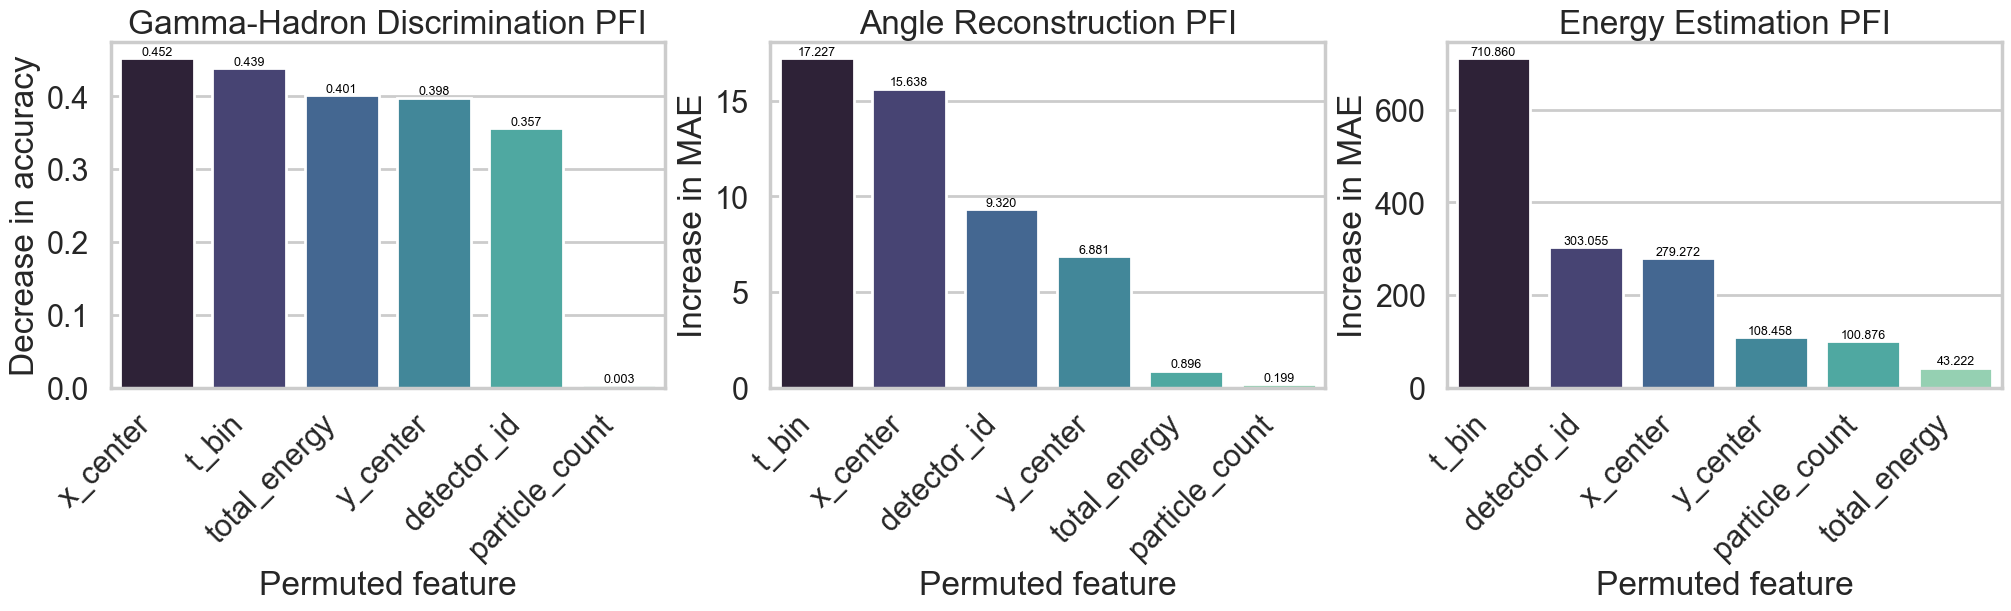

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

def _friendly_feature_name(raw_name: str) -> str:
    return raw_name.split("::", 1)[-1]

def plot_pfi_triptych(pfi_results, top_n=None, output_path=None):
    tasks_order = [
        ("particle", "Gamma-Hadron Discrimination PFI", "Decrease in accuracy"),
        ("angle", "Angle Reconstruction PFI", "Increase in MAE"),
        ("energy", "Energy Estimation PFI", "Increase in MAE"),
    ]
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
    sns.set_style("whitegrid")

    for ax, (task, title, ylabel) in zip(axes, tasks_order):
        subset = pfi_results[pfi_results["task"] == task].copy()
        subset = subset.sort_values("importance_delta", ascending=False)
        if top_n is not None:
            subset = subset.head(top_n)

        subset["feature_pretty"] = subset["feature"].apply(_friendly_feature_name)
        sns.barplot(
            data=subset,
            x="feature_pretty",
            y="importance_delta",
            hue="feature_pretty",
            palette="mako",
            ax=ax,
            legend=False,
        )
        ax.set_title(title)
        ax.set_xlabel("Permuted feature")
        ax.set_ylabel(ylabel)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        for bar_idx, (_, row) in enumerate(subset.iterrows()):
            ax.text(
                bar_idx,
                row["importance_delta"],
                f"{row['importance_delta']:.3f}",
                ha="center",
                va="bottom" if row["importance_delta"] >= 0 else "top",
                fontsize=9,
                color="black",
            )

    fig.subplots_adjust(bottom=0.28, wspace=0.25)

    if output_path is not None:
        fig.savefig(output_path, dpi=200, bbox_inches="tight")
    plt.show()

plot_pfi_triptych(
    pfi_results,
    top_n=None,
    output_path=ARTIFACTS_DIR / "diagnostics" / "permutation_importance_all_tasks.png",
)

Temporal - Modelo Auxiliar para patrones de atención, entrenar nuevamente el modelo para obtener las capas

In [116]:
# Para modelos ya entrenados: crear modelo auxiliar que extrae atención directamente de MHA
print("Creando modelo auxiliar para extraer atención...")

# Buscar las capas MultiHeadAttention
mha_angle = model.get_layer("mha_angle")
mha_class = model.get_layer("mha_class")
mha_energy = model.get_layer("mha_energy")

# Obtener las entradas normalizadas
pre_mha_angle = model.get_layer("pre_mha_norm_angle").output
pre_mha_class = model.get_layer("pre_mha_norm_class").output
pre_mha_energy = model.get_layer("pre_mha_norm_energy").output

# Extraer attention scores manualmente
_, attn_angle = mha_angle(pre_mha_angle, pre_mha_angle, return_attention_scores=True)
_, attn_class = mha_class(pre_mha_class, pre_mha_class, return_attention_scores=True)
_, attn_energy = mha_energy(pre_mha_energy, pre_mha_energy, return_attention_scores=True)

# Crear modelo auxiliar
attention_model = Model(
    inputs=model.inputs,
    outputs=[attn_class, attn_angle, attn_energy]
)

print("✓ Modelo de atención creado exitosamente")

Creando modelo auxiliar para extraer atención...
✓ Modelo de atención creado exitosamente


Extrayendo patrones de atención de 500 muestras...
8/8 [==============================] - 1s 20ms/step
Shapes de atención extraídas:
  Class (particle): (500, 1, 236, 236)
  Angle: (500, 1, 236, 236)
  Energy: (500, 1, 236, 236)

Estadísticas de longitudes válidas:
  Min: 21, Max: 411, Mean: 76.7

Procesando Gamma-Hadron Discrimination...
  Atención promedio: 0.0043 ± 0.0001
  Rango: [0.0041, 0.0048]

Procesando Zenith Angle Reconstruction...
  Atención promedio: 0.0042 ± 0.0000
  Rango: [0.0042, 0.0045]

Procesando Energy Estimation...
  Atención promedio: 0.0042 ± 0.0001
  Rango: [0.0039, 0.0043]


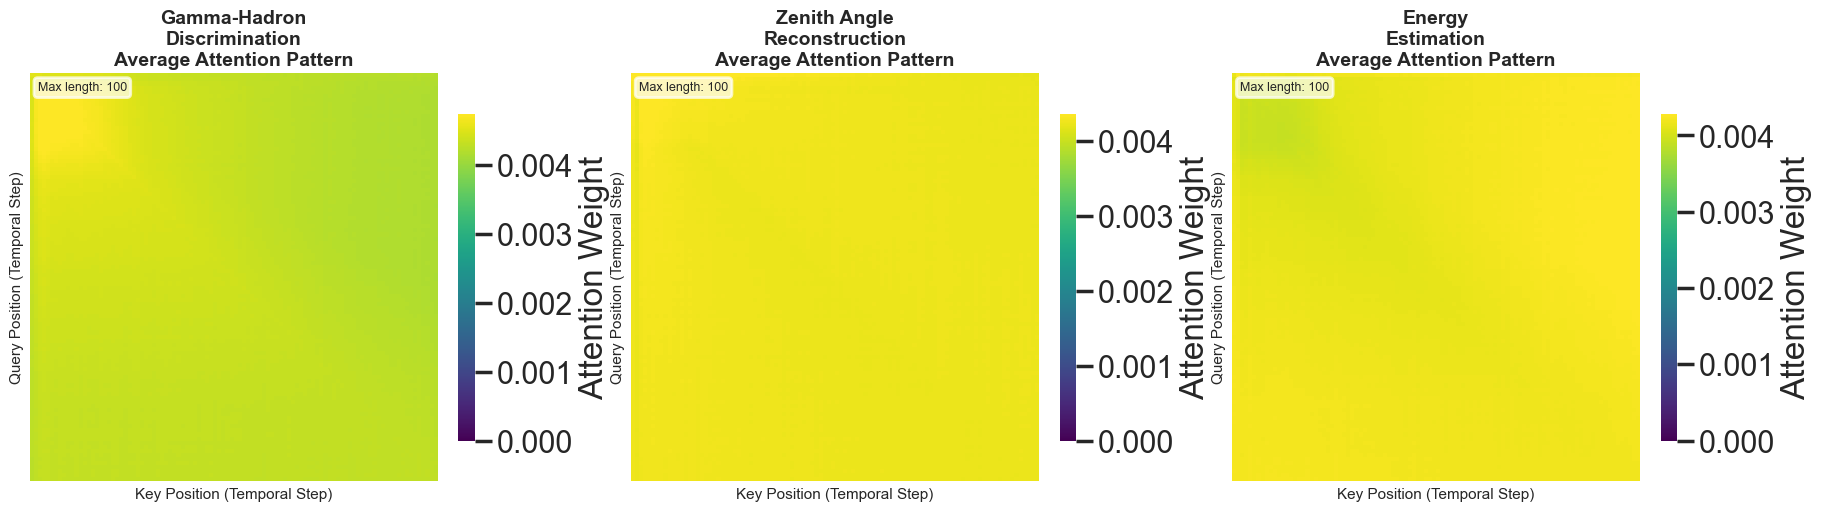


✓ Patrones de atención guardados en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_patterns_average.png


In [117]:
# ----------------------------- #
# Extraer patrones de atención del test set #
# ----------------------------- #
sample_size = min(500, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_indices]
Xg_sample = Xg_test[sample_indices]

print(f"Extrayendo patrones de atención de {sample_size} muestras...")
attention_scores = attention_model.predict([X_sample, Xg_sample], batch_size=64, verbose=1)

# attention_scores es una lista: [attn_class, attn_angle, attn_energy]
# Cada uno tiene shape: (batch, num_heads, seq_len, seq_len)
attn_class_scores, attn_angle_scores, attn_energy_scores = attention_scores

print(f"Shapes de atención extraídas:")
print(f"  Class (particle): {attn_class_scores.shape}")
print(f"  Angle: {attn_angle_scores.shape}")
print(f"  Energy: {attn_energy_scores.shape}")

# ----------------------------- #
# Calcular máscaras de padding #
# ----------------------------- #
# Tokens válidos son aquellos donde no todos los features son 0
valid_masks = ~np.all(np.isclose(X_sample, 0.0, atol=1e-8), axis=-1)
valid_lengths = valid_masks.sum(axis=-1)

print(f"\nEstadísticas de longitudes válidas:")
print(f"  Min: {valid_lengths.min()}, Max: {valid_lengths.max()}, Mean: {valid_lengths.mean():.1f}")

# ----------------------------- #
# Visualizar patrones promedio #
# ----------------------------- #
task_names = [
    "Gamma-Hadron\nDiscrimination",
    "Zenith Angle\nReconstruction", 
    "Energy\nEstimation"
]
task_attention_scores = [attn_class_scores, attn_angle_scores, attn_energy_scores]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for idx, (ax, task_name, attn_scores) in enumerate(zip(axes, task_names, task_attention_scores)):
    print(f"\nProcesando {task_name.replace(chr(10), ' ')}...")
    
    # Promedio sobre heads (dim=1)
    if attn_scores.ndim == 4:  # (batch, heads, seq, seq)
        attn_scores = attn_scores.mean(axis=1)  # -> (batch, seq, seq)
    
    # Limitar visualización a primeros 100 pasos temporales
    max_len = min(100, int(valid_lengths.max()))
    attn_avg = np.zeros((max_len, max_len))
    count_mat = np.zeros((max_len, max_len))
    
    # Acumular solo regiones válidas
    for sample_idx in range(len(attn_scores)):
        L = int(valid_lengths[sample_idx])
        if L > max_len:
            L = max_len
        if L > 0:
            attn_avg[:L, :L] += attn_scores[sample_idx, :L, :L]
            count_mat[:L, :L] += 1
    
    # Normalizar por cantidad de muestras válidas en cada posición
    attn_avg = np.divide(attn_avg, count_mat, where=count_mat > 0)
    attn_avg[count_mat == 0] = np.nan
    
    # Estadísticas
    valid_attn = attn_avg[~np.isnan(attn_avg)]
    print(f"  Atención promedio: {valid_attn.mean():.4f} ± {valid_attn.std():.4f}")
    print(f"  Rango: [{valid_attn.min():.4f}, {valid_attn.max():.4f}]")
    
    # Plot heatmap
    sns.heatmap(
        attn_avg,
        cmap="viridis",
        square=True,
        cbar=True,
        ax=ax,
        vmin=0,
        vmax=np.nanpercentile(attn_avg, 99),
        cbar_kws={"label": "Attention Weight", "shrink": 0.8},
        xticklabels=False,
        yticklabels=False,
    )
    
    ax.set_title(f"{task_name}\nAverage Attention Pattern", fontsize=14, fontweight="bold")
    ax.set_xlabel("Key Position (Temporal Step)", fontsize=11)
    ax.set_ylabel("Query Position (Temporal Step)", fontsize=11)
    
    # Añadir anotaciones de escala
    ax.text(0.02, 0.98, f"Max length: {max_len}", 
            transform=ax.transAxes, fontsize=9, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.savefig(plots_dir / "attention_patterns_average.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"\n✓ Patrones de atención guardados en: {plots_dir / 'attention_patterns_average.png'}")

ANÁLISIS AVANZADO DE INTERPRETABILIDAD DE ATENCIÓN

1. Separando patrones por performance del modelo...


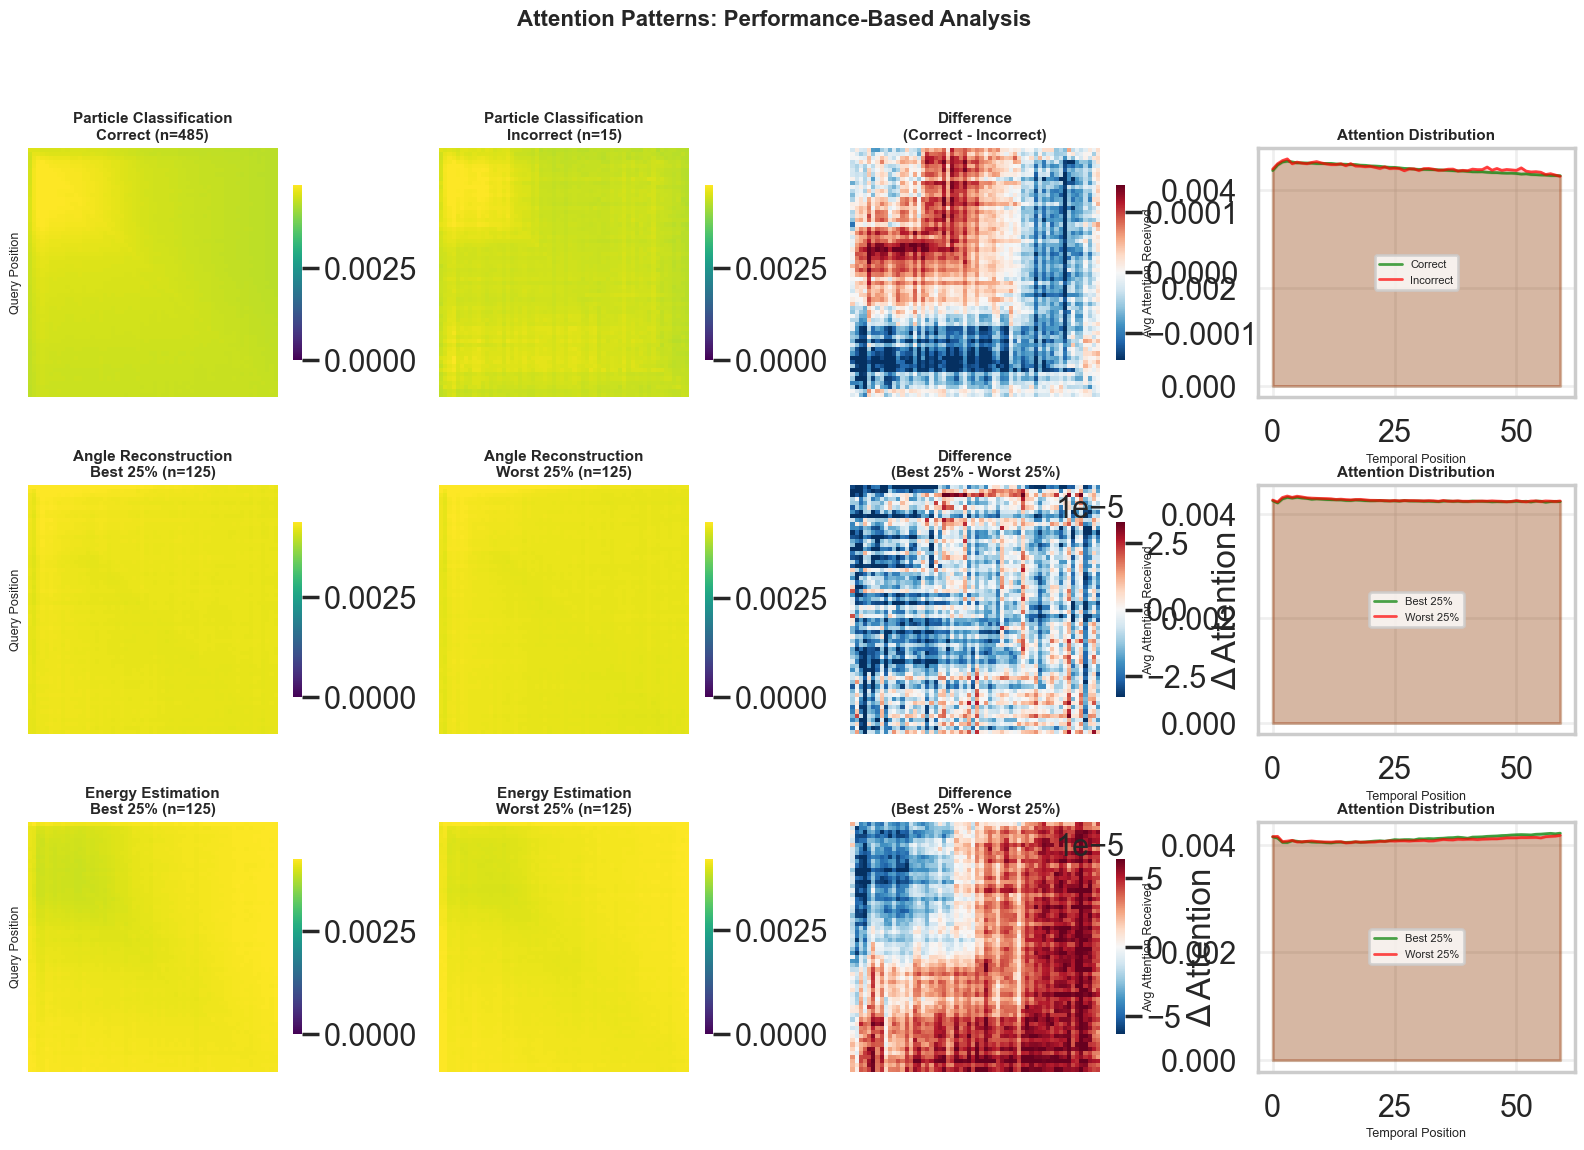

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_performance_comparison.png


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

# ----------------------------- #
# Análisis Avanzado de Patrones de Atención #
# ----------------------------- #

print("="*60)
print("ANÁLISIS AVANZADO DE INTERPRETABILIDAD DE ATENCIÓN")
print("="*60)

# 1. ANÁLISIS POR PERFORMANCE: Predicciones correctas vs incorrectas
# ----------------------------- #
print("\n1. Separando patrones por performance del modelo...")

# Definir subgrupos de performance
particle_correct_mask = pred_summary["particle_correct"].values[sample_indices]
angle_error = pred_summary["angle_abs_error_deg"].values[sample_indices]
energy_error = pred_summary["energy_abs_error_GeV"].values[sample_indices]

# Usar np.quantile en lugar de .quantile()
angle_good_mask = angle_error <= np.quantile(angle_error, 0.25)  # Mejor 25%
angle_bad_mask = angle_error >= np.quantile(angle_error, 0.75)   # Peor 25%

energy_good_mask = energy_error <= np.quantile(energy_error, 0.25)
energy_bad_mask = energy_error >= np.quantile(energy_error, 0.75)

# Comparar patrones de atención: buenas vs malas predicciones
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 4, figure=fig, hspace=0.35, wspace=0.3)

task_comparisons = [
    ("Particle Classification", attn_class_scores, particle_correct_mask, ~particle_correct_mask, "Correct", "Incorrect"),
    ("Angle Reconstruction", attn_angle_scores, angle_good_mask, angle_bad_mask, "Best 25%", "Worst 25%"),
    ("Energy Estimation", attn_energy_scores, energy_good_mask, energy_bad_mask, "Best 25%", "Worst 25%"),
]

for row_idx, (task_name, attn_scores, good_mask, bad_mask, good_label, bad_label) in enumerate(task_comparisons):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores
    
    max_len = 60
    
    # Patrón promedio para predicciones BUENAS
    attn_good = np.zeros((max_len, max_len))
    count_good = np.zeros((max_len, max_len))
    for idx in np.where(good_mask)[0]:
        L = min(int(valid_lengths[idx]), max_len)
        if L > 0:
            attn_good[:L, :L] += attn_3d[idx, :L, :L]
            count_good[:L, :L] += 1
    attn_good = np.divide(attn_good, count_good, where=count_good > 0)
    attn_good[count_good == 0] = np.nan
    
    # Patrón promedio para predicciones MALAS
    attn_bad = np.zeros((max_len, max_len))
    count_bad = np.zeros((max_len, max_len))
    for idx in np.where(bad_mask)[0]:
        L = min(int(valid_lengths[idx]), max_len)
        if L > 0:
            attn_bad[:L, :L] += attn_3d[idx, :L, :L]
            count_bad[:L, :L] += 1
    attn_bad = np.divide(attn_bad, count_bad, where=count_bad > 0)
    attn_bad[count_bad == 0] = np.nan
    
    # DIFERENCIA entre buenos y malos
    attn_diff = attn_good - attn_bad
    
    # Plot 1: Predicciones BUENAS
    ax1 = fig.add_subplot(gs[row_idx, 0])
    sns.heatmap(attn_good, cmap="viridis", square=True, cbar=True, ax=ax1,
                vmin=0, vmax=np.nanpercentile(attn_good, 99), 
                cbar_kws={"shrink": 0.7}, xticklabels=False, yticklabels=False)
    ax1.set_title(f"{task_name}\n{good_label} (n={good_mask.sum()})", fontweight="bold", fontsize=11)
    ax1.set_ylabel("Query Position", fontsize=9)
    
    # Plot 2: Predicciones MALAS
    ax2 = fig.add_subplot(gs[row_idx, 1])
    sns.heatmap(attn_bad, cmap="viridis", square=True, cbar=True, ax=ax2,
                vmin=0, vmax=np.nanpercentile(attn_bad, 99),
                cbar_kws={"shrink": 0.7}, xticklabels=False, yticklabels=False)
    ax2.set_title(f"{task_name}\n{bad_label} (n={bad_mask.sum()})", fontweight="bold", fontsize=11)
    
    # Plot 3: DIFERENCIA (Good - Bad)
    ax3 = fig.add_subplot(gs[row_idx, 2])
    vmax_diff = np.nanpercentile(np.abs(attn_diff), 95)
    sns.heatmap(attn_diff, cmap="RdBu_r", center=0, square=True, cbar=True, ax=ax3,
                vmin=-vmax_diff, vmax=vmax_diff,
                cbar_kws={"shrink": 0.7, "label": "Δ Attention"}, 
                xticklabels=False, yticklabels=False)
    ax3.set_title(f"Difference\n({good_label} - {bad_label})", fontweight="bold", fontsize=11)
    
    # Plot 4: Distribución de atención por posición (marginal)
    ax4 = fig.add_subplot(gs[row_idx, 3])
    
    # Atención promedio recibida por cada posición (columnas)
    attn_received_good = np.nanmean(attn_good, axis=0)[:max_len]
    attn_received_bad = np.nanmean(attn_bad, axis=0)[:max_len]
    
    positions = np.arange(len(attn_received_good))
    ax4.plot(positions, attn_received_good, label=good_label, color='green', linewidth=2, alpha=0.7)
    ax4.plot(positions, attn_received_bad, label=bad_label, color='red', linewidth=2, alpha=0.7)
    ax4.fill_between(positions, attn_received_good, alpha=0.2, color='green')
    ax4.fill_between(positions, attn_received_bad, alpha=0.2, color='red')
    ax4.set_xlabel("Temporal Position", fontsize=9)
    ax4.set_ylabel("Avg Attention Received", fontsize=9)
    ax4.set_title("Attention Distribution", fontweight="bold", fontsize=11)
    ax4.legend(fontsize=8)
    ax4.grid(alpha=0.3)

plt.suptitle("Attention Patterns: Performance-Based Analysis", fontsize=16, fontweight="bold", y=0.995)
plt.savefig(plots_dir / "attention_performance_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Guardado: {plots_dir / 'attention_performance_comparison.png'}")


2. Analizando importancia temporal de las posiciones...


C:\Users\Froxo\AppData\Local\Temp\ipykernel_27856\2089527437.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([early_attn, mid_attn, late_attn],
C:\Users\Froxo\AppData\Local\Temp\ipykernel_27856\2089527437.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([early_attn, mid_attn, late_attn],
C:\Users\Froxo\AppData\Local\Temp\ipykernel_27856\2089527437.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([early_attn, mid_attn, late_attn],


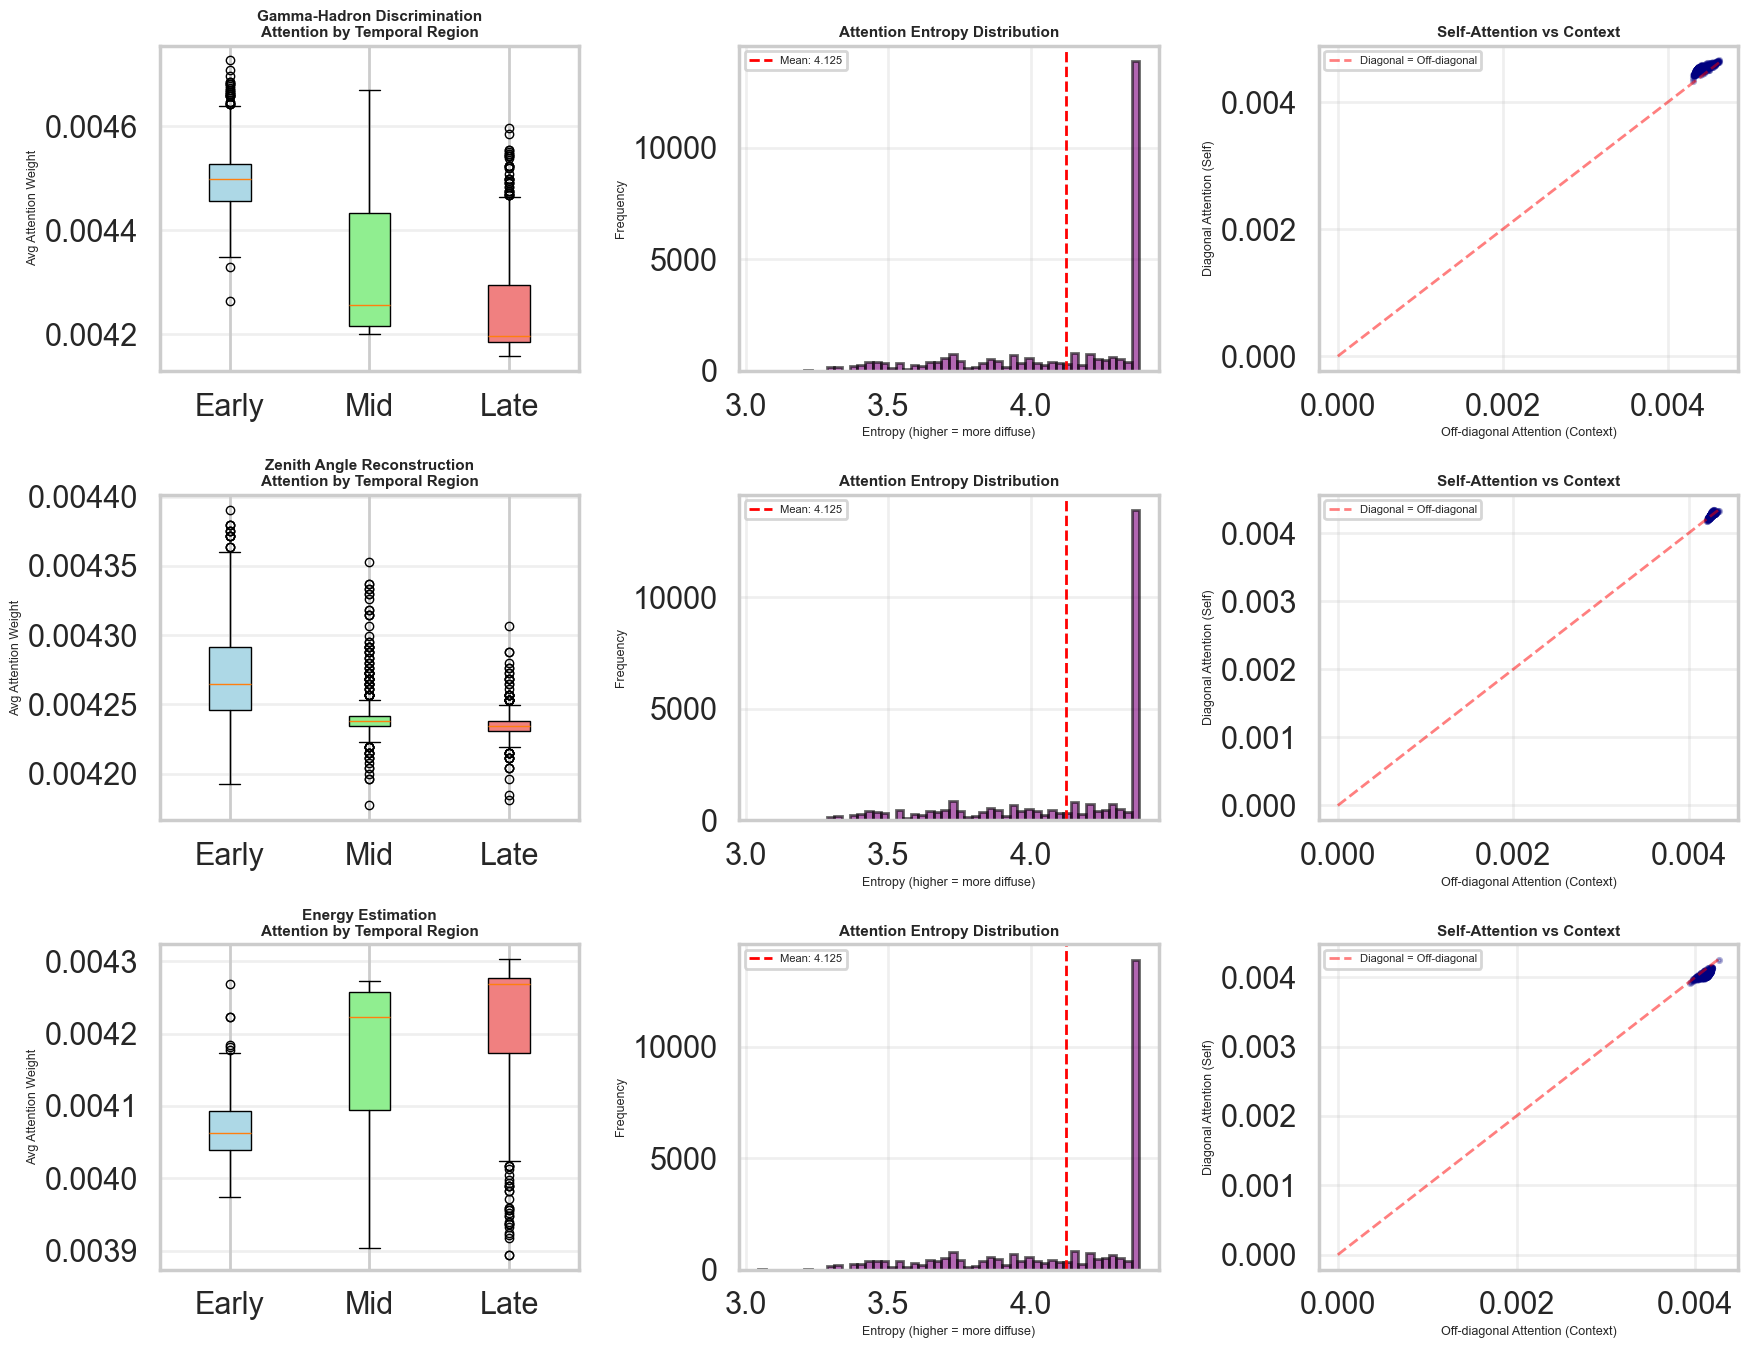

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_temporal_analysis.png


In [121]:
# 2. ANÁLISIS TEMPORAL: Importancia de posiciones early/mid/late
# ----------------------------- #
print("\n2. Analizando importancia temporal de las posiciones...")

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

for task_idx, (task_name, attn_scores) in enumerate([
    ("Gamma-Hadron Discrimination", attn_class_scores),
    ("Zenith Angle Reconstruction", attn_angle_scores),
    ("Energy Estimation", attn_energy_scores)
]):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores
    
    # Dividir secuencia en early/mid/late
    max_len = 80
    early_range = (0, max_len//3)
    mid_range = (max_len//3, 2*max_len//3)
    late_range = (2*max_len//3, max_len)
    
    # Calcular cuánta atención recibe cada región
    early_attn = []
    mid_attn = []
    late_attn = []
    
    for idx in range(len(attn_3d)):
        L = min(int(valid_lengths[idx]), max_len)
        if L > 10:
            attn_mat = attn_3d[idx, :L, :L]
            # Atención recibida por cada región (suma por columnas)
            attn_received = attn_mat.mean(axis=0)
            
            e_end = min(L, early_range[1])
            m_start = min(L, mid_range[0])
            m_end = min(L, mid_range[1])
            l_start = min(L, late_range[0])
            
            if e_end > early_range[0]:
                early_attn.append(attn_received[early_range[0]:e_end].mean())
            if m_end > m_start:
                mid_attn.append(attn_received[m_start:m_end].mean())
            if L > l_start:
                late_attn.append(attn_received[l_start:L].mean())
    
    # Plot 1: Box plot de atención por región temporal
    ax1 = axes[task_idx, 0]
    bp = ax1.boxplot([early_attn, mid_attn, late_attn], 
                      labels=['Early', 'Mid', 'Late'],
                      patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
        patch.set_facecolor(color)
    ax1.set_title(f"{task_name}\nAttention by Temporal Region", fontsize=11, fontweight="bold")
    ax1.set_ylabel("Avg Attention Weight", fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Entropía de atención (¿qué tan difusa es?)
    ax2 = axes[task_idx, 1]
    entropies = []
    for idx in range(len(attn_3d)):
        L = min(int(valid_lengths[idx]), max_len)
        if L > 5:
            attn_mat = attn_3d[idx, :L, :L]
            # Entropía de cada query (fila)
            for row in attn_mat:
                row_norm = row / (row.sum() + 1e-10)
                entropy = -np.sum(row_norm * np.log(row_norm + 1e-10))
                entropies.append(entropy)
    
    ax2.hist(entropies, bins=50, color='purple', alpha=0.6, edgecolor='black')
    ax2.axvline(np.mean(entropies), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(entropies):.3f}')
    ax2.set_title(f"Attention Entropy Distribution", fontsize=11, fontweight="bold")
    ax2.set_xlabel("Entropy (higher = more diffuse)", fontsize=9)
    ax2.set_ylabel("Frequency", fontsize=9)
    ax2.legend(fontsize=8)
    ax2.grid(alpha=0.3)
    
    # Plot 3: Self-attention strength (diagonal vs off-diagonal)
    ax3 = axes[task_idx, 2]
    diag_strengths = []
    offdiag_strengths = []
    
    for idx in range(len(attn_3d)):
        L = min(int(valid_lengths[idx]), max_len)
        if L > 5:
            attn_mat = attn_3d[idx, :L, :L]
            diag = np.diag(attn_mat).mean()
            mask = ~np.eye(L, dtype=bool)
            offdiag = attn_mat[mask].mean()
            diag_strengths.append(diag)
            offdiag_strengths.append(offdiag)
    
    ax3.scatter(offdiag_strengths, diag_strengths, alpha=0.3, s=10, color='navy')
    ax3.plot([0, max(offdiag_strengths)], [0, max(offdiag_strengths)], 
             'r--', linewidth=2, alpha=0.5, label='Diagonal = Off-diagonal')
    ax3.set_xlabel("Off-diagonal Attention (Context)", fontsize=9)
    ax3.set_ylabel("Diagonal Attention (Self)", fontsize=9)
    ax3.set_title("Self-Attention vs Context", fontsize=11, fontweight="bold")
    ax3.legend(fontsize=8)
    ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / "attention_temporal_analysis.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Guardado: {plots_dir / 'attention_temporal_analysis.png'}")


3. Analizando patrones por tipo de partícula y energía...


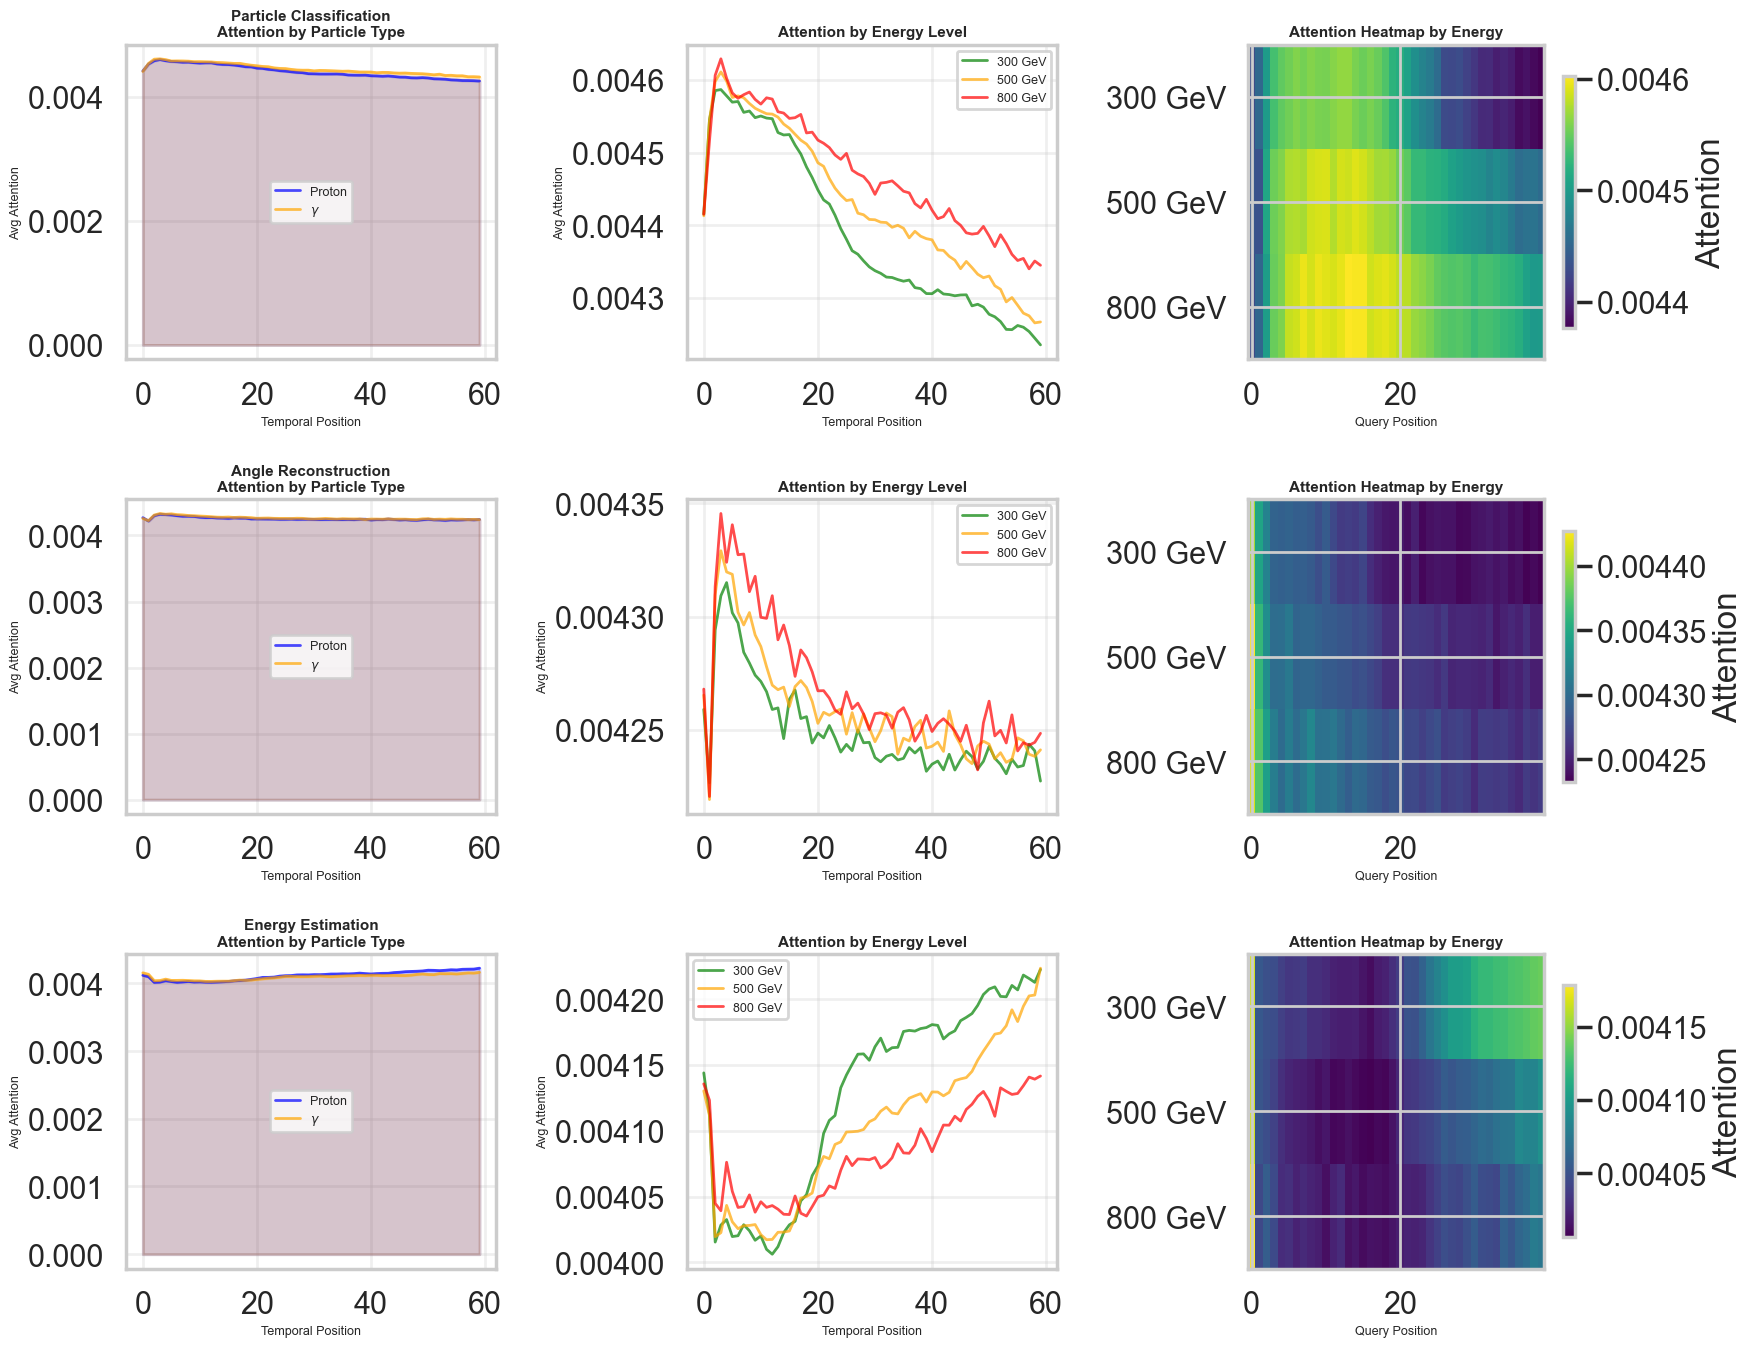

✓ Guardado: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics\attention_physics_analysis.png

ANÁLISIS COMPLETADO

Resumen de visualizaciones generadas:
1. attention_performance_comparison.png - Patrones según performance
2. attention_temporal_analysis.png - Análisis temporal y entropía
3. attention_physics_analysis.png - Análisis por física del evento


In [122]:
# 3. ANÁLISIS POR TIPO DE PARTÍCULA Y ENERGÍA
# ----------------------------- #
print("\n3. Analizando patrones por tipo de partícula y energía...")

particle_types = pred_summary["particle_true"].values[sample_indices]
energy_levels_sample = pred_summary["energy_level_true"].values[sample_indices]

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

for task_idx, (task_name, attn_scores) in enumerate([
    ("Particle Classification", attn_class_scores),
    ("Angle Reconstruction", attn_angle_scores),
    ("Energy Estimation", attn_energy_scores)
]):
    attn_3d = attn_scores.mean(axis=1) if attn_scores.ndim == 4 else attn_scores
    
    # Comparación: Photon vs Proton
    ax1 = axes[task_idx, 0]
    max_plot_len = 60
    
    for particle_type, color, label in [(0, 'blue', 'Proton'), (1, 'orange', r'$\gamma$')]:
        mask = particle_types == particle_type
        if mask.sum() > 0:
            # Crear matriz de atención con padding
            attention_by_pos = np.full((mask.sum(), max_plot_len), np.nan)
            valid_count = 0
            
            for array_idx, idx in enumerate(np.where(mask)[0]):
                L = min(int(valid_lengths[idx]), max_plot_len)
                if L > 5:
                    attn_mat = attn_3d[idx, :L, :L]
                    attention_by_pos[valid_count, :L] = attn_mat.mean(axis=0)
                    valid_count += 1
            
            if valid_count > 0:
                # Calcular promedio ignorando NaN
                avg_attn = np.nanmean(attention_by_pos[:valid_count], axis=0)
                positions = np.arange(len(avg_attn))
                ax1.plot(positions, avg_attn, label=label, color=color, linewidth=2, alpha=0.7)
                ax1.fill_between(positions, avg_attn, alpha=0.2, color=color)
    
    ax1.set_title(f"{task_name}\nAttention by Particle Type", fontsize=11, fontweight="bold")
    ax1.set_xlabel("Temporal Position", fontsize=9)
    ax1.set_ylabel("Avg Attention", fontsize=9)
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Comparación por nivel de energía
    ax2 = axes[task_idx, 1]
    energy_colors = {"3E2": "green", "5E2": "orange", "8E2": "red"}
    energy_labels = {"3E2": "300 GeV", "5E2": "500 GeV", "8E2": "800 GeV"}
    
    for energy_level in ["3E2", "5E2", "8E2"]:
        mask = energy_levels_sample == energy_level
        if mask.sum() > 0:
            # Crear matriz de atención con padding
            attention_by_pos = np.full((mask.sum(), max_plot_len), np.nan)
            valid_count = 0
            
            for array_idx, idx in enumerate(np.where(mask)[0]):
                L = min(int(valid_lengths[idx]), max_plot_len)
                if L > 5:
                    attn_mat = attn_3d[idx, :L, :L]
                    attention_by_pos[valid_count, :L] = attn_mat.mean(axis=0)
                    valid_count += 1
            
            if valid_count > 0:
                avg_attn = np.nanmean(attention_by_pos[:valid_count], axis=0)
                positions = np.arange(len(avg_attn))
                ax2.plot(positions, avg_attn, label=energy_labels[energy_level], 
                        color=energy_colors[energy_level], linewidth=2, alpha=0.7)
    
    ax2.set_title(f"Attention by Energy Level", fontsize=11, fontweight="bold")
    ax2.set_xlabel("Temporal Position", fontsize=9)
    ax2.set_ylabel("Avg Attention", fontsize=9)
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)
    
    # Heatmap agregado por energía
    ax3 = axes[task_idx, 2]
    energy_attn_summary = []
    energy_labels_list = []
    max_heatmap_len = 40
    
    for energy_level in ["3E2", "5E2", "8E2"]:
        mask = energy_levels_sample == energy_level
        if mask.sum() > 0:
            attn_avg = np.zeros((max_heatmap_len, max_heatmap_len))
            count = np.zeros((max_heatmap_len, max_heatmap_len))
            for idx in np.where(mask)[0]:
                L = min(int(valid_lengths[idx]), max_heatmap_len)
                if L > 5:
                    attn_avg[:L, :L] += attn_3d[idx, :L, :L]
                    count[:L, :L] += 1
            
            # Normalizar y extraer promedio por fila
            attn_avg = np.divide(attn_avg, count, where=count > 0)
            # Calcular promedio por fila (ignorando ceros)
            row_means = []
            for i in range(max_heatmap_len):
                if count[i, :].sum() > 0:
                    valid_vals = attn_avg[i, count[i, :] > 0]
                    row_means.append(valid_vals.mean() if len(valid_vals) > 0 else 0)
                else:
                    row_means.append(0)
            
            energy_attn_summary.append(row_means)
            energy_labels_list.append(energy_labels[energy_level])
    
    if energy_attn_summary:
        im = ax3.imshow(energy_attn_summary, aspect='auto', cmap='viridis', interpolation='nearest')
        ax3.set_yticks(range(len(energy_labels_list)))
        ax3.set_yticklabels(energy_labels_list)
        ax3.set_xlabel("Query Position", fontsize=9)
        ax3.set_title("Attention Heatmap by Energy", fontsize=11, fontweight="bold")
        plt.colorbar(im, ax=ax3, shrink=0.8, label="Attention")

plt.tight_layout()
plt.savefig(plots_dir / "attention_physics_analysis.png", dpi=200, bbox_inches="tight")
plt.show()

print(f"✓ Guardado: {plots_dir / 'attention_physics_analysis.png'}")

print("\n" + "="*60)
print("ANÁLISIS COMPLETADO")
print("="*60)
print("\nResumen de visualizaciones generadas:")
print("1. attention_performance_comparison.png - Patrones según performance")
print("2. attention_temporal_analysis.png - Análisis temporal y entropía")
print("3. attention_physics_analysis.png - Análisis por física del evento")